# Basic AML/MDS Chimerism Dynamics Analysis

## Project Overview

This notebook focuses on the foundational analysis of chimerism dynamics in AML/MDS transplant patients. The analysis centers on **feature engineering** and **exploratory data analysis** to understand how CD3+ and CD3- chimerism changes over time can predict transplant outcomes.

### Key Research Questions

**Tier 1 (Primary Focus):**
- Can dynamic changes of CD3+ chimerism at Day 30, 60, and 100 predict disease relapse?
- Do specific trend patterns (upward, downward, fluctuating) correlate with outcomes?
- Can percentage changes (e.g., ≥20% increase from Day 30 to Day 100) improve prediction accuracy?

**Tier 2:**
- Can CD3+ chimerism dynamics predict other transplant outcomes (OS, GVHD, GRFS)?

**Tier 3:**
- Do interactions between CD3+ and CD3- chimerism improve prediction models?
- Can chimerism variability metrics enhance outcome prediction?

### Analysis Approach

1. **Feature Engineering**: Create dynamic change indicators and statistical summaries
2. **Pattern Classification**: Categorize chimerism trends into interpretable labels
3. **Exploratory Analysis**: Visualize distributions and correlations
4. **Predictive Modeling**: Test various feature combinations for outcome prediction
5. **Model Evaluation**: Compare performance across different feature sets

## 1. Environment Setup and Data Loading

Import necessary libraries and load the preprocessed dataset.

In [32]:
# Core data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import sys
import os
import joblib
import glob
from datetime import datetime

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn.decomposition import PCA

# Advanced clustering and dimensionality reduction
from sklearn.cluster import KMeans
import umap.umap_ as umap
from skfuzzy import cmeans
import skfuzzy as fuzz

# Genetic algorithm and advanced ML
from deap import base, creator, tools, algorithms
import random

# 3D plotting
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuration
warnings.filterwarnings("ignore")
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(message)s", force=True)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully")
print(f"📅 Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📅 Analysis started at: 2025-07-18 19:13:43


In [33]:
def load_and_inspect_data(file_path="preprocessed_ml_for_aml_mds.csv"):
    """
    Load the preprocessed dataset and perform initial inspection.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing preprocessed data
        
    Returns:
    --------
    pd.DataFrame
        Loaded dataset
    """
    print("📂 Loading preprocessed dataset...")
    
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Dataset loaded successfully")
        print(f"📊 Dataset shape: {df.shape}")
        print(f"🔢 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Display basic information
        print(f"\n=== Dataset Overview ===")
        print(f"Rows: {len(df):,}")
        print(f"Columns: {len(df.columns):,}")
        print(f"Total missing values: {df.isnull().sum().sum():,}")
        
        # Show column types
        print(f"\n=== Data Types ===")
        dtype_counts = df.dtypes.value_counts()
        for dtype, count in dtype_counts.items():
            print(f"{dtype}: {count} columns")
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Error: File '{file_path}' not found")
        print("📁 Available files in current directory:")
        for file in os.listdir('.'):
            if file.endswith('.csv'):
                print(f"   - {file}")
        return None
    except Exception as e:
        print(f"❌ Error loading dataset: {str(e)}")
        return None

# Load the dataset
df = load_and_inspect_data()

if df is not None:
    # Display first few rows
    print(f"\n=== First 3 Rows ===")
    display(df.head(3))
    
    # Show column names
    print(f"\n=== Column Names ===")
    print(f"Total columns: {len(df.columns)}")
    print("Key columns identified:")
    
    chimerism_cols = [col for col in df.columns if 'cd3' in col.lower()]
    outcome_cols = [col for col in df.columns if col.startswith('y_')]
    
    print(f"  - Chimerism columns ({len(chimerism_cols)}): {chimerism_cols[:5]}...")
    print(f"  - Outcome columns ({len(outcome_cols)}): {outcome_cols[:5]}...")

📂 Loading preprocessed dataset...
✅ Dataset loaded successfully
📊 Dataset shape: (258, 64)
🔢 Memory usage: 0.22 MB

=== Dataset Overview ===
Rows: 258
Columns: 64
Total missing values: 3,634

=== Data Types ===
float64: 31 columns
int64: 24 columns
object: 9 columns

=== First 3 Rows ===


,age,disease,disease_risk_index,hct_ci_score,time_from_diagnosis_to_alloSCT,aml_eln_risk_category,disease_state_at_transplant,mrd_status_prior_to_transplant,donor_type,cd34+_dose,...,y_relapse,y_cgvhd,y_time_to_onset,y_cgvhd_nih,y_time_to_onset_nih,y_agvhd,y_agvhd_grade_at_onset,y_agvhd_time_to_onset,y_agvhd_highest_grade,y_agvhd_time_to_highest_grade
0,61,2,3,2,253.0,NaN,NaN,NaN,2,5.40,...,0,0,NaN,NaN,NaN,1,1.0,159.0,NaN,NaN
1,53,5,2,0,218.0,NaN,NaN,NaN,2,5.04,...,0,1,145.0,1.0,374.0,0,NaN,NaN,NaN,NaN
2,63,1,2,0,162.0,3.0,1.0,1.0,1,4.66,...,1,0,NaN,NaN,NaN,1,1.0,78.0,NaN,NaN



=== Column Names ===
Total columns: 64
Key columns identified:
  - Chimerism columns (7): ['cd34+_dose', 'd30_cd3+', 'd30_cd3-', 'd60_cd3+', 'd60_cd3-']...
  - Outcome columns (17): ['y_grfs_days', 'y_rfs_days', 'y_rfs', 'y_os_days', 'y_cause_of_death']...


## 2. Chimerism Dynamics Feature Engineering

Create sophisticated features to capture the dynamic nature of chimerism changes over time.

In [34]:
def create_chimerism_dynamics_features(df):
    """
    Engineer comprehensive chimerism dynamics features.
    
    This function creates multiple types of features:
    1. Time-point differences (Day 30→60, Day 60→100)
    2. Statistical summaries (mean, std, coefficient of variation)
    3. Demographic ratios (age relationships)
    4. Pattern classifications (trend labels)
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with chimerism measurements
        
    Returns:
    --------
    pd.DataFrame
        Enhanced dataframe with new features
    """
    print("🔧 Engineering chimerism dynamics features...")
    df_enhanced = df.copy()
    
    # Check for required columns
    required_cols = ['d30_cd3+', 'd60_cd3+', 'd100_cd3+', 'd30_cd3-', 'd60_cd3-', 'd100_cd3-']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"⚠️ Missing required columns: {missing_cols}")
        return df_enhanced
    
    # Convert chimerism columns to numeric first
    for col in required_cols:
        if col in df_enhanced.columns:
            df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce')
    
    # 1. TIME-POINT DIFFERENCES
    print("   📈 Creating time-point difference features...")
    
    # Calculate differences between consecutive time points
    df_enhanced["d(30-60)_cd3+"] = df_enhanced["d30_cd3+"] - df_enhanced["d60_cd3+"]
    df_enhanced["d(60-100)_cd3+"] = df_enhanced["d60_cd3+"] - df_enhanced["d100_cd3+"]
    df_enhanced["d(30-60)_cd3-"] = df_enhanced["d30_cd3-"] - df_enhanced["d60_cd3-"]
    df_enhanced["d(60-100)_cd3-"] = df_enhanced["d60_cd3-"] - df_enhanced["d100_cd3-"]
    
    # Calculate overall change (Day 30 to Day 100)
    df_enhanced["d(30-100)_cd3+"] = df_enhanced["d30_cd3+"] - df_enhanced["d100_cd3+"]
    df_enhanced["d(30-100)_cd3-"] = df_enhanced["d30_cd3-"] - df_enhanced["d100_cd3-"]
    
    # 2. DEMOGRAPHIC FEATURES
    print("   👥 Creating demographic ratio features...")
    
    if 'age' in df.columns and 'donor_age' in df.columns:
        # Convert to numeric and avoid division by zero
        df_enhanced['age'] = pd.to_numeric(df_enhanced['age'], errors='coerce')
        df_enhanced['donor_age'] = pd.to_numeric(df_enhanced['donor_age'], errors='coerce')
        
        df_enhanced["age_receiver_donor_ratio"] = df_enhanced["age"] / (df_enhanced["donor_age"] + 0.001)
        df_enhanced["age_difference"] = df_enhanced["age"] - df_enhanced["donor_age"]
    
    # 3. STATISTICAL SUMMARY FEATURES
    print("   📊 Creating statistical summary features...")
    
    # Mean chimerism levels across time points
    cd3_pos_cols = ["d30_cd3+", "d60_cd3+", "d100_cd3+"]
    cd3_neg_cols = ["d30_cd3-", "d60_cd3-", "d100_cd3-"]
    
    df_enhanced["mean_cd3+"] = df_enhanced[cd3_pos_cols].mean(axis=1)
    df_enhanced["mean_cd3-"] = df_enhanced[cd3_neg_cols].mean(axis=1)
    
    # Standard deviation (variability measure)
    df_enhanced["std_cd3+"] = df_enhanced[cd3_pos_cols].std(axis=1)
    df_enhanced["std_cd3-"] = df_enhanced[cd3_neg_cols].std(axis=1)
    
    # Coefficient of variation (normalized variability)
    df_enhanced["cv_cd3+"] = df_enhanced["std_cd3+"] / (df_enhanced["mean_cd3+"] + 0.001)
    df_enhanced["cv_cd3-"] = df_enhanced["std_cd3-"] / (df_enhanced["mean_cd3-"] + 0.001)
    
    # Min and Max values
    df_enhanced["min_cd3+"] = df_enhanced[cd3_pos_cols].min(axis=1)
    df_enhanced["max_cd3+"] = df_enhanced[cd3_pos_cols].max(axis=1)
    df_enhanced["min_cd3-"] = df_enhanced[cd3_neg_cols].min(axis=1)
    df_enhanced["max_cd3-"] = df_enhanced[cd3_neg_cols].max(axis=1)
    
    # Range (max - min)
    df_enhanced["range_cd3+"] = df_enhanced["max_cd3+"] - df_enhanced["min_cd3+"]
    df_enhanced["range_cd3-"] = df_enhanced["max_cd3-"] - df_enhanced["min_cd3-"]
    
    # 4. PERCENTAGE CHANGE FEATURES
    print("   📈 Creating percentage change features...")
    
    # Percentage changes (avoiding division by zero)
    df_enhanced["pct_change_30_100_cd3+"] = (
        (df_enhanced["d100_cd3+"] - df_enhanced["d30_cd3+"]) / (df_enhanced["d30_cd3+"] + 0.001) * 100
    )
    df_enhanced["pct_change_30_100_cd3-"] = (
        (df_enhanced["d100_cd3-"] - df_enhanced["d30_cd3-"]) / (df_enhanced["d30_cd3-"] + 0.001) * 100
    )
    
    # 5. SLOPE FEATURES (Linear trend)
    print("   📉 Creating slope/trend features...")
    
    # Simple slope calculation (change per time unit)
    time_points = np.array([30, 60, 100])
    
    def calculate_slope(row, cols):
        """Calculate linear slope for chimerism values over time."""
        values = row[cols].values
        # Convert to numeric and check for valid data
        try:
            values = pd.to_numeric(values, errors='coerce')
            if pd.isna(values).any() or len(values) < 2:
                return np.nan
            # Filter out any remaining non-numeric values
            valid_mask = ~pd.isna(values)
            if valid_mask.sum() < 2:
                return np.nan
            valid_values = values[valid_mask]
            valid_times = time_points[valid_mask]
            return np.polyfit(valid_times, valid_values, 1)[0]  # slope coefficient
        except (ValueError, TypeError, np.linalg.LinAlgError):
            return np.nan
    
    df_enhanced["slope_cd3+"] = df_enhanced.apply(
        lambda row: calculate_slope(row, cd3_pos_cols), axis=1
    )
    df_enhanced["slope_cd3-"] = df_enhanced.apply(
        lambda row: calculate_slope(row, cd3_neg_cols), axis=1
    )
    
    print(f"✅ Feature engineering completed. Added {len(df_enhanced.columns) - len(df.columns)} new features.")
    
    return df_enhanced

# Apply feature engineering
if df is not None:
    df_enhanced = create_chimerism_dynamics_features(df)
    
    # Show summary of new features
    new_features = [col for col in df_enhanced.columns if col not in df.columns]
    print(f"\n=== New Features Created ({len(new_features)}) ===")
    for i, feature in enumerate(new_features, 1):
        print(f"{i:2d}. {feature}")
    
    # Display sample of enhanced data
    print(f"\n=== Enhanced Dataset Sample ===")
    chimerism_features = [col for col in new_features if 'cd3' in col][:8]
    if chimerism_features:
        display(df_enhanced[chimerism_features].head())

🔧 Engineering chimerism dynamics features...
   📈 Creating time-point difference features...
   👥 Creating demographic ratio features...
   📊 Creating statistical summary features...
   📈 Creating percentage change features...
   📉 Creating slope/trend features...
✅ Feature engineering completed. Added 24 new features.

=== New Features Created (24) ===
 1. d(30-60)_cd3+
 2. d(60-100)_cd3+
 3. d(30-60)_cd3-
 4. d(60-100)_cd3-
 5. d(30-100)_cd3+
 6. d(30-100)_cd3-
 7. age_receiver_donor_ratio
 8. age_difference
 9. mean_cd3+
10. mean_cd3-
11. std_cd3+
12. std_cd3-
13. cv_cd3+
14. cv_cd3-
15. min_cd3+
16. max_cd3+
17. min_cd3-
18. max_cd3-
19. range_cd3+
20. range_cd3-
21. pct_change_30_100_cd3+
22. pct_change_30_100_cd3-
23. slope_cd3+
24. slope_cd3-

=== Enhanced Dataset Sample ===


,d(30-60)_cd3+,d(60-100)_cd3+,d(30-60)_cd3-,d(60-100)_cd3-,d(30-100)_cd3+,d(30-100)_cd3-,mean_cd3+,mean_cd3-
0,-10.0,6.0,-3.0,-9.0,-4.0,-12.0,91.666667,93.000000
1,0.0,0.0,1.0,-1.0,0.0,0.0,96.000000,99.666667
2,1.0,2.0,0.0,0.0,3.0,0.0,97.666667,100.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,99.000000,100.000000


## 3. Chimerism Pattern Classification

Categorize chimerism changes into interpretable pattern labels for clinical understanding.

In [35]:
def assign_chimerism_trend_labels(df, col_a, col_b, threshold=0.5):
    """
    Assign trend labels based on chimerism changes between time periods.
    
    This function categorizes the dynamic patterns of chimerism changes
    into clinically meaningful labels that can be used for prediction
    and interpretation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    col_a : str
        First time period change column (e.g., 'd(30-60)_cd3+')
    col_b : str
        Second time period change column (e.g., 'd(60-100)_cd3+')
    threshold : float
        Threshold for considering a change significant
        
    Returns:
    --------
    pd.Series
        Series with trend labels
    """
    # Convert to categorical based on sign and magnitude
    def categorize_change(x, threshold):
        if pd.isna(x):
            return np.nan
        elif x > threshold:
            return 1  # Increase
        elif x < -threshold:
            return -1  # Decrease
        else:
            return 0  # Stable
    
    # Categorize changes for both periods
    change_a = df[col_a].apply(lambda x: categorize_change(x, threshold))
    change_b = df[col_b].apply(lambda x: categorize_change(x, threshold))
    
    # Define trend patterns based on consecutive changes
    def assign_pattern(a, b):
        if pd.isna(a) or pd.isna(b):
            return 'unknown'
        elif a == -1 and b == -1:
            return 'consistently_downward'
        elif a == 1 and b == 1:
            return 'consistently_upward'
        elif a == 0 and b == 0:
            return 'stable'
        elif (a == -1 and b == 1) or (a == 1 and b == -1):
            return 'fluctuating'
        elif a == -1 and b == 0:
            return 'downward_then_stable'
        elif a == 0 and b == -1:
            return 'stable_then_downward'
        elif a == 1 and b == 0:
            return 'upward_then_stable'
        elif a == 0 and b == 1:
            return 'stable_then_upward'
        else:
            return 'other'
    
    # Apply pattern assignment
    patterns = pd.Series(
        [assign_pattern(a, b) for a, b in zip(change_a, change_b)],
        index=df.index
    )
    
    return patterns

def create_pattern_features(df):
    """
    Create pattern-based features for chimerism dynamics.
    """
    print("🏷️ Creating chimerism pattern labels...")
    
    df_patterns = df.copy()
    
    # Check for required difference columns
    required_diff_cols = ['d(30-60)_cd3+', 'd(60-100)_cd3+', 'd(30-60)_cd3-', 'd(60-100)_cd3-']
    missing_cols = [col for col in required_diff_cols if col not in df.columns]
    
    if missing_cols:
        print(f"⚠️ Missing required columns for pattern analysis: {missing_cols}")
        return df_patterns
    
    # Create pattern labels
    df_patterns['cd3+_trend_pattern'] = assign_chimerism_trend_labels(
        df, 'd(30-60)_cd3+', 'd(60-100)_cd3+'
    )
    
    df_patterns['cd3-_trend_pattern'] = assign_chimerism_trend_labels(
        df, 'd(30-60)_cd3-', 'd(60-100)_cd3-'
    )
    
    # Create simplified binary patterns
    def simplify_pattern(pattern):
        if pd.isna(pattern) or pattern == 'unknown':
            return 'unknown'
        elif 'upward' in pattern:
            return 'increasing'
        elif 'downward' in pattern:
            return 'decreasing'
        elif pattern == 'stable':
            return 'stable'
        elif pattern == 'fluctuating':
            return 'fluctuating'
        else:
            return 'mixed'
    
    df_patterns['cd3+_simple_pattern'] = df_patterns['cd3+_trend_pattern'].apply(simplify_pattern)
    df_patterns['cd3-_simple_pattern'] = df_patterns['cd3-_trend_pattern'].apply(simplify_pattern)
    
    # Create numerical encoding for ML models
    pattern_encoder = {
        'unknown': 0,
        'decreasing': 1,
        'stable': 2,
        'increasing': 3,
        'fluctuating': 4,
        'mixed': 5
    }
    
    df_patterns['cd3+_pattern_encoded'] = df_patterns['cd3+_simple_pattern'].map(pattern_encoder)
    df_patterns['cd3-_pattern_encoded'] = df_patterns['cd3-_simple_pattern'].map(pattern_encoder)
    
    print("✅ Pattern features created successfully")
    
    return df_patterns

# Apply pattern analysis
if 'df_enhanced' in locals():
    df_with_patterns = create_pattern_features(df_enhanced)
    
    # Analyze pattern distributions
    print(f"\n=== CD3+ Chimerism Pattern Distribution ===")
    cd3_pos_patterns = df_with_patterns['cd3+_simple_pattern'].value_counts()
    for pattern, count in cd3_pos_patterns.items():
        percentage = (count / len(df_with_patterns)) * 100
        print(f"{pattern:12s}: {count:3d} ({percentage:5.1f}%)")
    
    print(f"\n=== CD3- Chimerism Pattern Distribution ===")
    cd3_neg_patterns = df_with_patterns['cd3-_simple_pattern'].value_counts()
    for pattern, count in cd3_neg_patterns.items():
        percentage = (count / len(df_with_patterns)) * 100
        print(f"{pattern:12s}: {count:3d} ({percentage:5.1f}%)")
    
    # Show example pattern assignments
    print(f"\n=== Sample Pattern Assignments ===")
    pattern_cols = ['d(30-60)_cd3+', 'd(60-100)_cd3+', 'cd3+_simple_pattern',
                   'd(30-60)_cd3-', 'd(60-100)_cd3-', 'cd3-_simple_pattern']
    display(df_with_patterns[pattern_cols].head(10))

🏷️ Creating chimerism pattern labels...
✅ Pattern features created successfully

=== CD3+ Chimerism Pattern Distribution ===
fluctuating :  67 ( 26.0%)
increasing  :  65 ( 25.2%)
unknown     :  46 ( 17.8%)
stable      :  41 ( 15.9%)
decreasing  :  39 ( 15.1%)

=== CD3- Chimerism Pattern Distribution ===
stable      : 128 ( 49.6%)
increasing  :  52 ( 20.2%)
unknown     :  46 ( 17.8%)
decreasing  :  17 (  6.6%)
fluctuating :  15 (  5.8%)

=== Sample Pattern Assignments ===


,d(30-60)_cd3+,d(60-100)_cd3+,cd3+_simple_pattern,d(30-60)_cd3-,d(60-100)_cd3-,cd3-_simple_pattern
0,-10.0,6.0,fluctuating,-3.0,-9.0,decreasing
1,0.0,0.0,stable,1.0,-1.0,fluctuating
2,1.0,2.0,increasing,0.0,0.0,stable
3,NaN,NaN,unknown,NaN,NaN,unknown
4,NaN,NaN,unknown,NaN,NaN,unknown
5,0.0,2.0,increasing,0.0,0.0,stable
6,9.0,79.0,increasing,0.0,11.0,increasing
7,0.0,0.0,stable,0.0,0.0,stable
8,40.0,NaN,unknown,7.0,NaN,unknown
9,4.0,-4.0,fluctuating,0.0,0.0,stable


## 4. Outcome Association Analysis

Explore relationships between chimerism patterns and transplant outcomes.

🔍 Analyzing pattern-outcome associations...
📊 Analyzing 5 outcomes: ['y_relapse', 'y_death', 'y_agvhd', 'y_cgvhd', 'y_rfs']

📈 CD3+ CHIMERISM PATTERN ASSOCIATIONS

🎯 Y_RELAPSE:

🎯 Y_DEATH:

🎯 Y_AGVHD:

🎯 Y_CGVHD:

🎯 Y_RFS:

📉 CD3- CHIMERISM PATTERN ASSOCIATIONS

🎯 Y_RELAPSE:

🎯 Y_DEATH:

🎯 Y_AGVHD:

🎯 Y_CGVHD:

🎯 Y_RFS:

📊 Creating association visualizations...


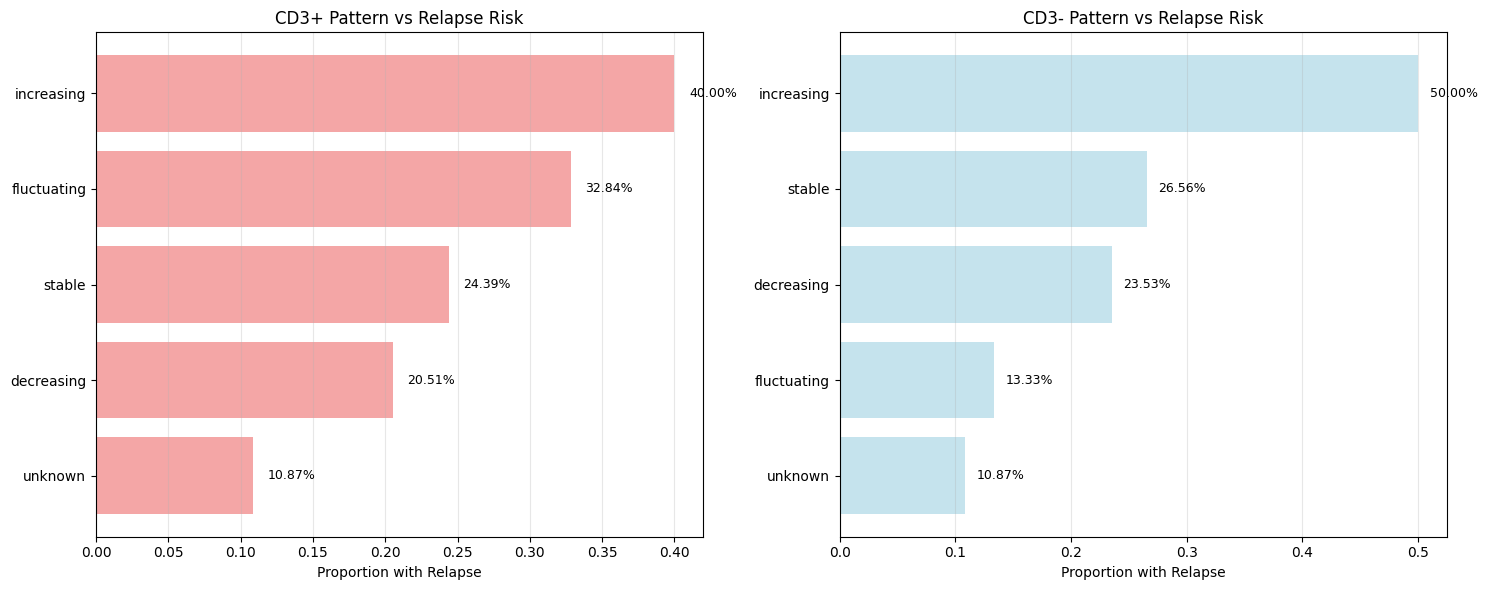

In [36]:
def analyze_pattern_outcome_associations(df):
    """
    Analyze associations between chimerism patterns and transplant outcomes.
    
    This function creates cross-tabulations and calculates proportions
    to understand which patterns are associated with different outcomes.
    """
    print("🔍 Analyzing pattern-outcome associations...")
    
    # Identify outcome columns
    outcome_cols = [col for col in df.columns if col.startswith('y_')]
    key_outcomes = ['y_relapse', 'y_death', 'y_agvhd', 'y_cgvhd', 'y_rfs']
    available_outcomes = [col for col in key_outcomes if col in outcome_cols]
    
    if not available_outcomes:
        print("⚠️ No outcome variables found")
        return
    
    print(f"📊 Analyzing {len(available_outcomes)} outcomes: {available_outcomes}")
    
    # Analyze CD3+ patterns
    if 'cd3+_simple_pattern' in df.columns:
        print(f"\n{'='*60}")
        print(f"📈 CD3+ CHIMERISM PATTERN ASSOCIATIONS")
        print(f"{'='*60}")
        
        for outcome in available_outcomes:
            if outcome in df.columns:
                print(f"\n🎯 {outcome.upper()}:")
                
                # Create cross-tabulation
                crosstab = pd.crosstab(
                    df['cd3+_simple_pattern'], 
                    df[outcome], 
                    margins=True, 
                    normalize='index'
                )
                
                # Display proportions (excluding totals)
                crosstab_display = crosstab.iloc[:-1, :-1]  # Remove margin row and column
                
                if crosstab_display.shape[1] >= 2:  # Binary outcome
                    print(f"   Pattern breakdown (proportion with outcome = 1):")
                    for pattern in crosstab_display.index:
                        if pattern != 'unknown' and 1 in crosstab_display.columns:
                            prop = crosstab_display.loc[pattern, 1]
                            count = pd.crosstab(df['cd3+_simple_pattern'], df[outcome]).loc[pattern, 1]
                            total = pd.crosstab(df['cd3+_simple_pattern'], df[outcome]).loc[pattern].sum()
                            print(f"     {pattern:12s}: {prop:5.1%} ({count}/{total})")
    
    # Analyze CD3- patterns
    if 'cd3-_simple_pattern' in df.columns:
        print(f"\n{'='*60}")
        print(f"📉 CD3- CHIMERISM PATTERN ASSOCIATIONS")
        print(f"{'='*60}")
        
        for outcome in available_outcomes:
            if outcome in df.columns:
                print(f"\n🎯 {outcome.upper()}:")
                
                # Create cross-tabulation
                crosstab = pd.crosstab(
                    df['cd3-_simple_pattern'], 
                    df[outcome], 
                    margins=True, 
                    normalize='index'
                )
                
                # Display proportions (excluding totals)
                crosstab_display = crosstab.iloc[:-1, :-1]
                
                if crosstab_display.shape[1] >= 2:  # Binary outcome
                    print(f"   Pattern breakdown (proportion with outcome = 1):")
                    for pattern in crosstab_display.index:
                        if pattern != 'unknown' and 1 in crosstab_display.columns:
                            prop = crosstab_display.loc[pattern, 1]
                            count = pd.crosstab(df['cd3-_simple_pattern'], df[outcome]).loc[pattern, 1]
                            total = pd.crosstab(df['cd3-_simple_pattern'], df[outcome]).loc[pattern].sum()
                            print(f"     {pattern:12s}: {prop:5.1%} ({count}/{total})")

def create_association_visualization(df):
    """
    Create visualizations of pattern-outcome associations.
    """
    print("\n📊 Creating association visualizations...")
    
    # Focus on relapse outcome if available
    if 'y_relapse' not in df.columns:
        print("⚠️ y_relapse column not found for visualization")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # CD3+ pattern vs relapse
    if 'cd3+_simple_pattern' in df.columns:
        crosstab_cd3pos = pd.crosstab(df['cd3+_simple_pattern'], df['y_relapse'], normalize='index')
        if 1 in crosstab_cd3pos.columns:
            relapse_props = crosstab_cd3pos[1].sort_values(ascending=True)
            
            axes[0].barh(range(len(relapse_props)), relapse_props.values, 
                        color='lightcoral', alpha=0.7)
            axes[0].set_yticks(range(len(relapse_props)))
            axes[0].set_yticklabels(relapse_props.index)
            axes[0].set_xlabel('Proportion with Relapse')
            axes[0].set_title('CD3+ Pattern vs Relapse Risk')
            axes[0].grid(axis='x', alpha=0.3)
            
            # Add value labels
            for i, v in enumerate(relapse_props.values):
                axes[0].text(v + 0.01, i, f'{v:.2%}', va='center', fontsize=9)
    
    # CD3- pattern vs relapse
    if 'cd3-_simple_pattern' in df.columns:
        crosstab_cd3neg = pd.crosstab(df['cd3-_simple_pattern'], df['y_relapse'], normalize='index')
        if 1 in crosstab_cd3neg.columns:
            relapse_props = crosstab_cd3neg[1].sort_values(ascending=True)
            
            axes[1].barh(range(len(relapse_props)), relapse_props.values, 
                        color='lightblue', alpha=0.7)
            axes[1].set_yticks(range(len(relapse_props)))
            axes[1].set_yticklabels(relapse_props.index)
            axes[1].set_xlabel('Proportion with Relapse')
            axes[1].set_title('CD3- Pattern vs Relapse Risk')
            axes[1].grid(axis='x', alpha=0.3)
            
            # Add value labels
            for i, v in enumerate(relapse_props.values):
                axes[1].text(v + 0.01, i, f'{v:.2%}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Run association analysis
if 'df_with_patterns' in locals():
    analyze_pattern_outcome_associations(df_with_patterns)
    create_association_visualization(df_with_patterns)

## 5. Data Preprocessing and Quality Assessment

Prepare data for machine learning by handling missing values and filtering patients.

In [37]:
def advanced_missing_value_imputation(df):
    """
    Apply sophisticated missing value imputation strategies.
    
    This function uses multiple imputation strategies based on
    the nature and amount of missing data in each column.
    """
    print("🔧 Applying advanced missing value imputation...")
    
    df_imputed = df.copy()
    
    # Separate column types
    numerical_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"   📊 Processing {len(numerical_cols)} numerical columns")
    print(f"   🏷️ Processing {len(categorical_cols)} categorical columns")
    
    # 1. NUMERICAL COLUMNS IMPUTATION
    if numerical_cols:
        # Analyze missing patterns
        missing_analysis = df_imputed[numerical_cols].isnull().sum().sort_values(ascending=False)
        high_missing = missing_analysis[missing_analysis > len(df_imputed) * 0.5].index.tolist()
        moderate_missing = missing_analysis[(missing_analysis > 0) & (missing_analysis <= len(df_imputed) * 0.5)].index.tolist()
        
        print(f"   📉 High missing (>50%): {len(high_missing)} columns")
        print(f"   📊 Moderate missing (≤50%): {len(moderate_missing)} columns")
        
        # For columns with high missing values, use simple median imputation
        if high_missing:
            print(f"      Applying median imputation to high-missing columns")
            simple_imputer = SimpleImputer(strategy='median')
            df_imputed[high_missing] = simple_imputer.fit_transform(df_imputed[high_missing])
        
        # For columns with moderate missing values, use more sophisticated methods
        if moderate_missing:
            print(f"      Applying iterative imputation to moderate-missing columns")
            try:
                # Use Iterative Imputer (MICE) for better accuracy
                iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
                df_imputed[moderate_missing] = iterative_imputer.fit_transform(df_imputed[moderate_missing])
            except Exception as e:
                print(f"      ⚠️ Iterative imputation failed: {str(e)}")
                print(f"      Falling back to median imputation")
                fallback_imputer = SimpleImputer(strategy='median')
                df_imputed[moderate_missing] = fallback_imputer.fit_transform(df_imputed[moderate_missing])
    
    # 2. CATEGORICAL COLUMNS IMPUTATION
    if categorical_cols:
        print(f"   🏷️ Applying mode imputation to categorical columns")
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_imputed[categorical_cols] = cat_imputer.fit_transform(df_imputed[categorical_cols])
    
    # 3. VERIFICATION
    remaining_missing = df_imputed.isnull().sum().sum()
    print(f"✅ Imputation completed. Remaining missing values: {remaining_missing}")
    
    return df_imputed

def prepare_ml_dataset(df):
    """
    Prepare the dataset for machine learning analysis.
    
    This function:
    1. Filters for AML/MDS patients (disease == 1)
    2. Removes columns with excessive missing data
    3. Applies imputation strategies
    4. Splits features and targets
    """
    print("🎯 Preparing dataset for machine learning...")
    
    # 1. PATIENT FILTERING
    if 'disease' in df.columns:
        aml_mds_patients = df[df['disease'] == 1].copy()
        print(f"   👥 Filtered to AML/MDS patients: {len(aml_mds_patients)} from {len(df)}")
    else:
        print("   ⚠️ 'disease' column not found, using all patients")
        aml_mds_patients = df.copy()
    
    # 2. FEATURE SELECTION AND CLEANUP
    # Remove columns with too much missing data or not suitable for ML
    exclude_columns = [
        'dose_dli', 'dose_dli_2', 'indication_for_dli', 'post_dli_gvhd',
        'grade_at_onset', 'time_to_onset', 'highest_grade', 'dli',
        'aml_eln_risk_category', 'disease_risk_index', 
        'time_from_diagnosis_to_alloSCT', 'hct_ci_score'
    ]
    
    # Identify feature columns (non-outcome variables)
    feature_cols = [col for col in aml_mds_patients.columns 
                   if not col.startswith('y_') and col not in exclude_columns]
    
    # Identify outcome columns
    classification_labels = ['y_rfs', 'y_death', 'y_relapse', 'y_cgvhd', 'y_agvhd']
    regression_labels = ['y_os_days', 'y_rfs_days']
    
    # Filter to available columns
    available_class_labels = [col for col in classification_labels if col in aml_mds_patients.columns]
    available_reg_labels = [col for col in regression_labels if col in aml_mds_patients.columns]
    
    print(f"   📊 Features: {len(feature_cols)} columns")
    print(f"   🎯 Classification targets: {len(available_class_labels)} columns")
    print(f"   📈 Regression targets: {len(available_reg_labels)} columns")
    
    # 3. REQUIRE MINIMUM CHIMERISM DATA
    # Remove patients without key chimerism measurements
    key_chimerism_cols = ['d100_cd3+', 'd100_cd3-']
    before_filter = len(aml_mds_patients)
    
    for col in key_chimerism_cols:
        if col in aml_mds_patients.columns:
            aml_mds_patients = aml_mds_patients.dropna(subset=[col])
    
    after_filter = len(aml_mds_patients)
    print(f"   🧹 Removed patients missing key chimerism data: {before_filter - after_filter}")
    
    # 4. EXTRACT AND PROCESS DATA
    X = aml_mds_patients[feature_cols].copy()
    y_classification = aml_mds_patients[available_class_labels].copy() if available_class_labels else pd.DataFrame()
    y_regression = aml_mds_patients[available_reg_labels].copy() if available_reg_labels else pd.DataFrame()
    
    # 5. APPLY IMPUTATION
    X_imputed = advanced_missing_value_imputation(X)
    
    # 6. RESET INDICES
    X_imputed.reset_index(drop=True, inplace=True)
    y_classification.reset_index(drop=True, inplace=True)
    y_regression.reset_index(drop=True, inplace=True)
    
    print(f"✅ Dataset preparation completed")
    print(f"   Final shapes: X={X_imputed.shape}, y_class={y_classification.shape}, y_reg={y_regression.shape}")
    
    return X_imputed, y_classification, y_regression

# Prepare the dataset
if 'df_with_patterns' in locals():
    X_processed, y_classification, y_regression = prepare_ml_dataset(df_with_patterns)
    
    # Display summary statistics
    print(f"\n=== Processed Dataset Summary ===")
    print(f"Features (X): {X_processed.shape[0]} samples × {X_processed.shape[1]} features")
    print(f"Classification targets: {y_classification.shape[1]} outcomes")
    print(f"Regression targets: {y_regression.shape[1]} outcomes")
    
    # Show feature types
    if not X_processed.empty:
        print(f"\n=== Feature Information ===")
        feature_info = X_processed.dtypes.value_counts()
        for dtype, count in feature_info.items():
            print(f"{dtype}: {count} features")
        
        print(f"\nMissing values check: {X_processed.isnull().sum().sum()} total missing")
        
        # Show key chimerism features
        chimerism_features = [col for col in X_processed.columns if 'cd3' in col.lower()]
        print(f"\nChimerism-related features ({len(chimerism_features)}):")
        for i, feature in enumerate(chimerism_features[:10], 1):
            print(f"{i:2d}. {feature}")
        if len(chimerism_features) > 10:
            print(f"    ... and {len(chimerism_features) - 10} more")

🎯 Preparing dataset for machine learning...
   👥 Filtered to AML/MDS patients: 182 from 258
   📊 Features: 65 columns
   🎯 Classification targets: 5 columns
   📈 Regression targets: 2 columns
   🧹 Removed patients missing key chimerism data: 25
🔧 Applying advanced missing value imputation...
   📊 Processing 57 numerical columns
   🏷️ Processing 8 categorical columns
   📉 High missing (>50%): 0 columns
   📊 Moderate missing (≤50%): 22 columns
      Applying iterative imputation to moderate-missing columns
   🏷️ Applying mode imputation to categorical columns
✅ Imputation completed. Remaining missing values: 0
✅ Dataset preparation completed
   Final shapes: X=(157, 65), y_class=(157, 5), y_reg=(157, 2)

=== Processed Dataset Summary ===
Features (X): 157 samples × 65 features
Classification targets: 5 outcomes
Regression targets: 2 outcomes

=== Feature Information ===
float64: 39 features
int64: 18 features
object: 8 features

Missing values check: 0 total missing

Chimerism-related fe

## 6. Exploratory Data Analysis and Visualization

Create comprehensive visualizations to understand data distributions and relationships.

📊 Creating comprehensive exploratory data analysis...

📈 1. Feature Distribution Analysis


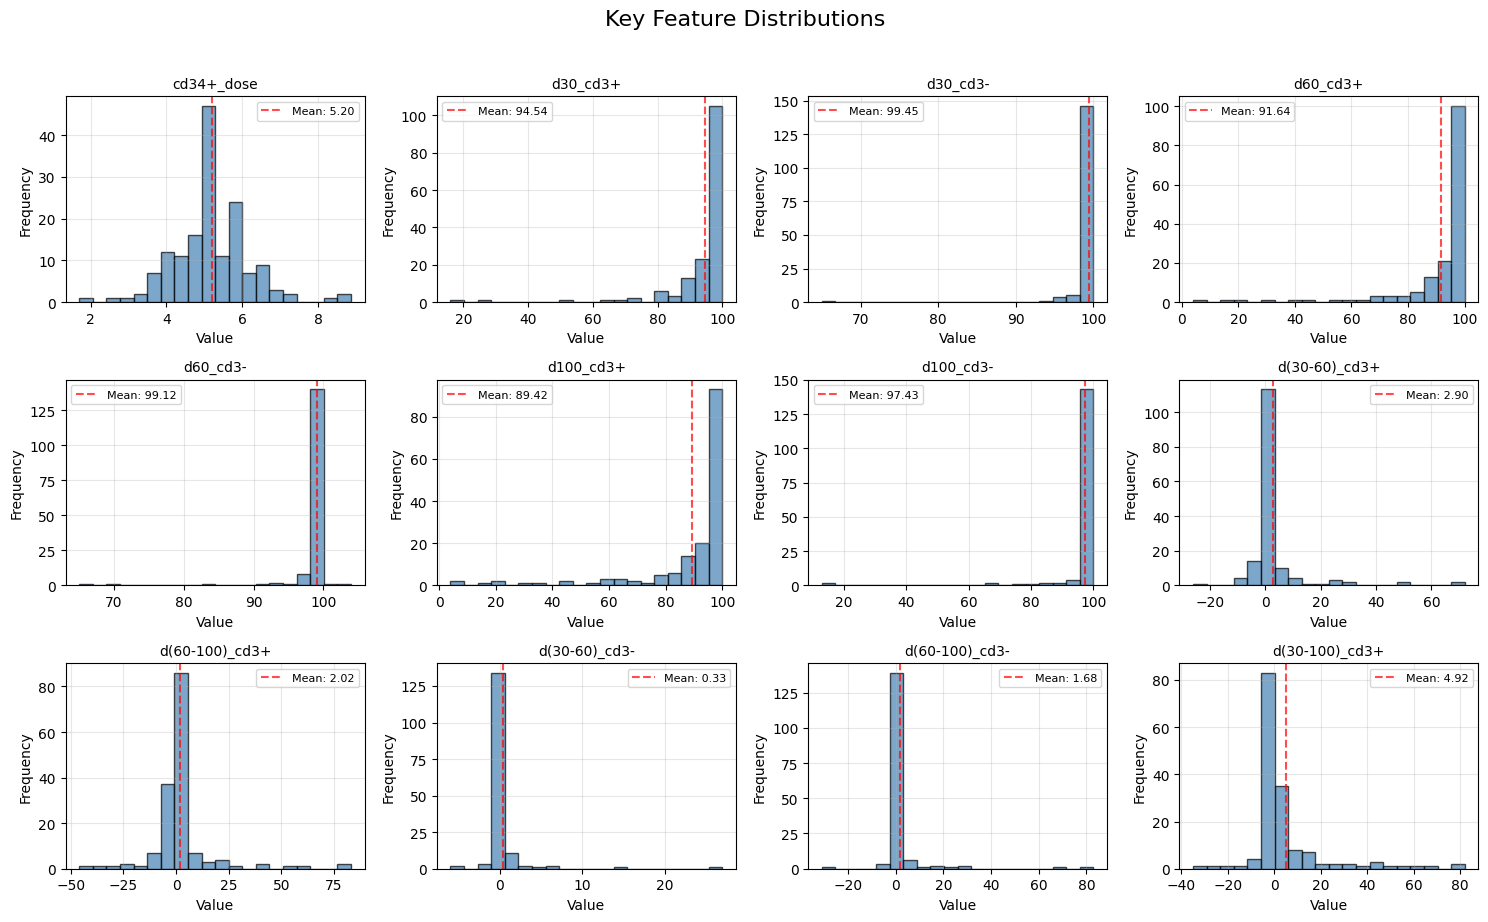


🔗 2. Feature Correlation Analysis


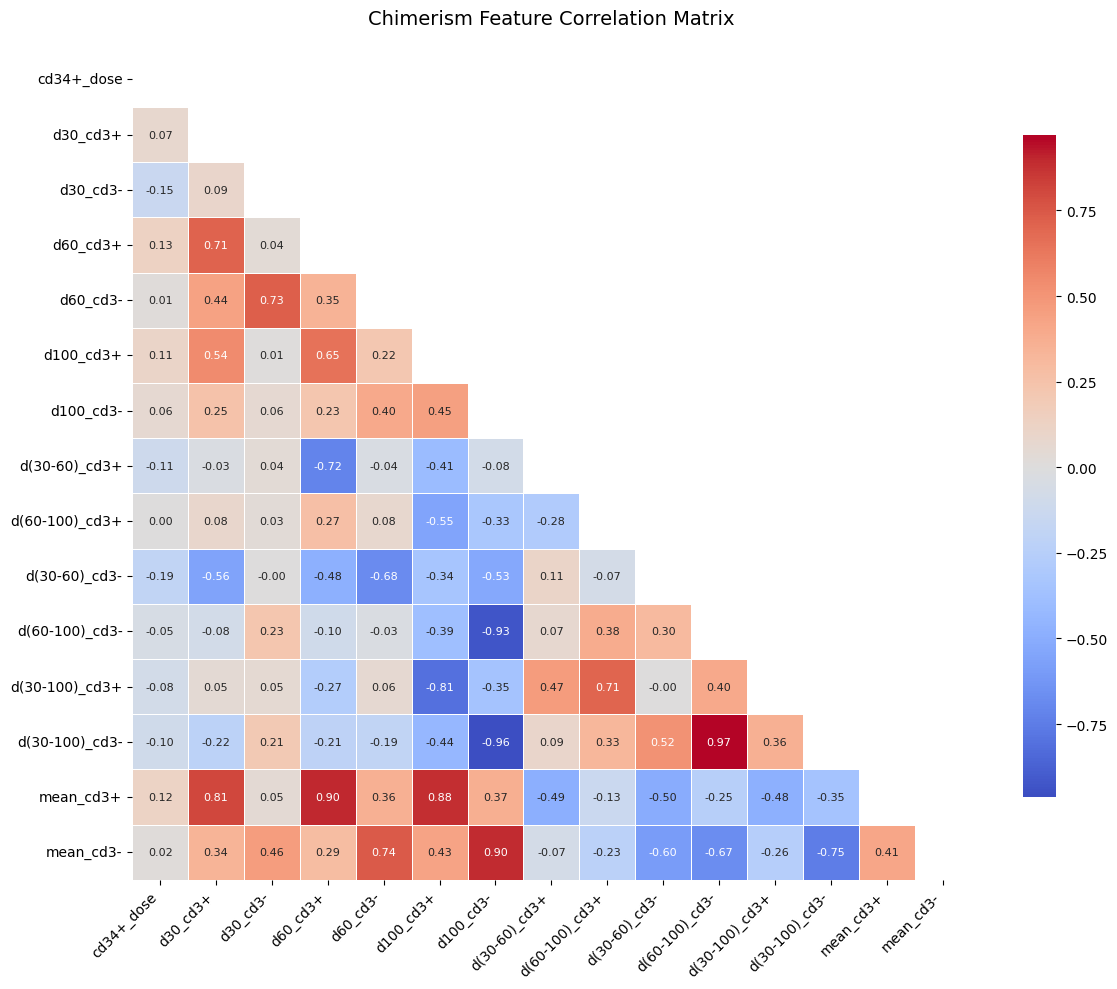


⚠️ Highly correlated feature pairs (|r| > 0.8):
   d30_cd3+ ↔ mean_cd3+: 0.812
   d60_cd3+ ↔ mean_cd3+: 0.899
   d100_cd3+ ↔ d(30-100)_cd3+: -0.805
   d100_cd3+ ↔ mean_cd3+: 0.883
   d100_cd3- ↔ d(60-100)_cd3-: -0.926
   d100_cd3- ↔ d(30-100)_cd3-: -0.963
   d100_cd3- ↔ mean_cd3-: 0.896
   d(60-100)_cd3- ↔ d(30-100)_cd3-: 0.972

🎯 3. Outcome Distribution Analysis


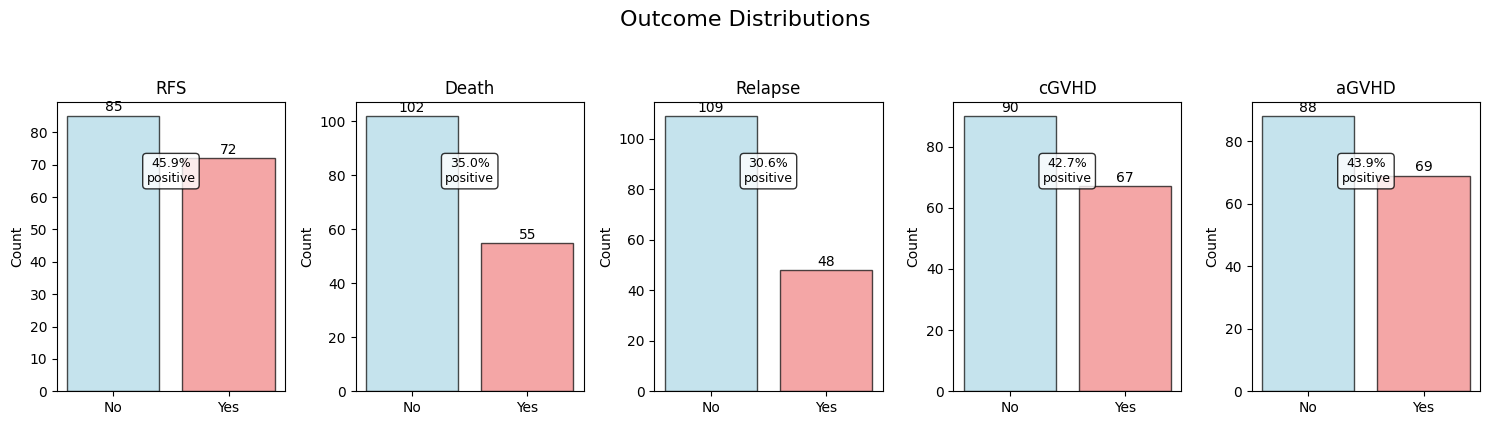


📈 4. Chimerism Time Series Analysis


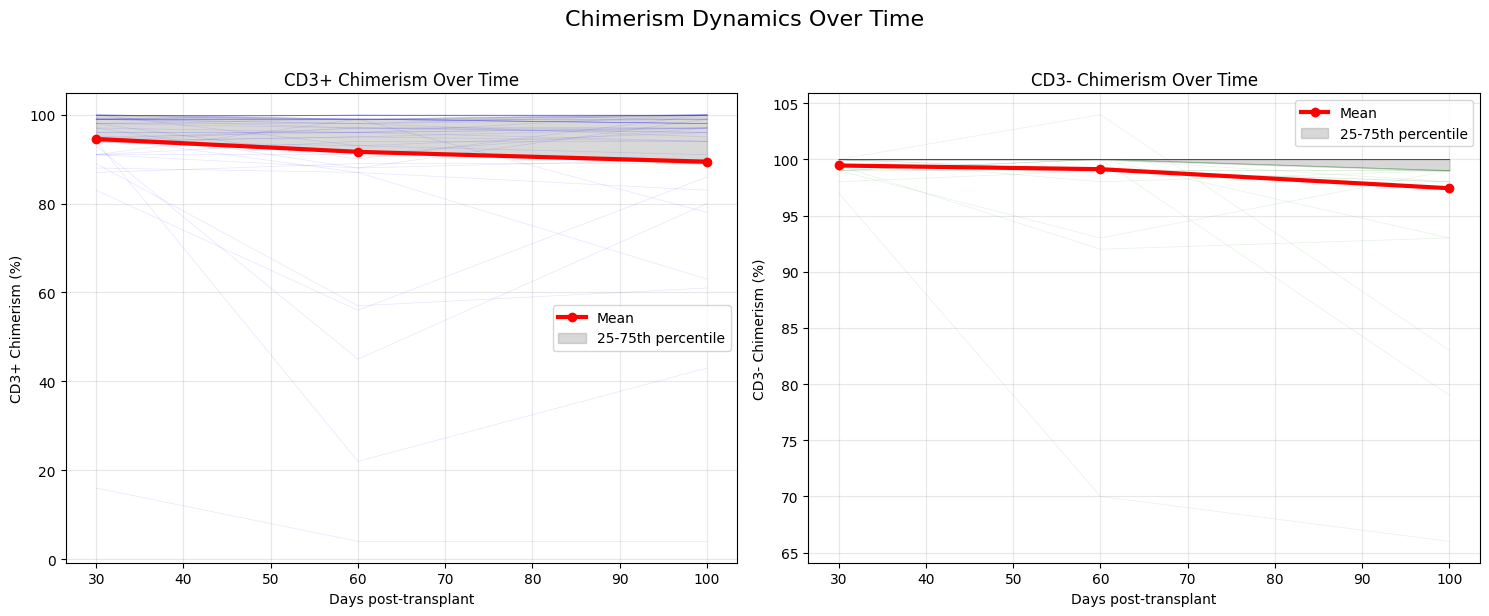

In [38]:
def create_comprehensive_eda(X, y_classification):
    """
    Create comprehensive exploratory data analysis visualizations.
    """
    print("📊 Creating comprehensive exploratory data analysis...")
    
    # 1. FEATURE DISTRIBUTION ANALYSIS
    print("\n📈 1. Feature Distribution Analysis")
    
    # Focus on key chimerism features
    chimerism_cols = [col for col in X.columns if any(x in col.lower() for x in ['cd3', 'chimerism'])]
    key_features = chimerism_cols[:12] if chimerism_cols else X.columns[:12]
    
    if key_features:
        n_features = len(key_features)
        n_cols = min(4, n_features)
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, feature in enumerate(key_features):
            row, col = i // n_cols, i % n_cols
            
            # Create histogram
            axes[row, col].hist(X[feature].dropna(), bins=20, alpha=0.7, color='steelblue', edgecolor='black')
            axes[row, col].set_title(f'{feature}', fontsize=10)
            axes[row, col].set_xlabel('Value')
            axes[row, col].set_ylabel('Frequency')
            axes[row, col].grid(True, alpha=0.3)
            
            # Add basic statistics
            mean_val = X[feature].mean()
            axes[row, col].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
            axes[row, col].legend(fontsize=8)
        
        # Hide empty subplots
        for i in range(len(key_features), n_rows * n_cols):
            row, col = i // n_cols, i % n_cols
            axes[row, col].set_visible(False)
        
        plt.suptitle('Key Feature Distributions', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
    
    # 2. CORRELATION ANALYSIS
    print("\n🔗 2. Feature Correlation Analysis")
    
    if chimerism_cols:
        # Focus on chimerism-related features for correlation
        corr_features = chimerism_cols[:15]  # Limit to avoid overcrowding
        
        correlation_matrix = X[corr_features].corr()
        
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Show only lower triangle
        sns.heatmap(
            correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f', 
            annot_kws={"size": 8}, 
            linewidths=0.5,
            cbar_kws={"shrink": 0.8}
        )
        plt.title('Chimerism Feature Correlation Matrix', fontsize=14, pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Identify highly correlated features
        high_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.8:
                    high_corr_pairs.append((
                        correlation_matrix.columns[i],
                        correlation_matrix.columns[j],
                        corr_val
                    ))
        
        if high_corr_pairs:
            print(f"\n⚠️ Highly correlated feature pairs (|r| > 0.8):")
            for feat1, feat2, corr in high_corr_pairs:
                print(f"   {feat1} ↔ {feat2}: {corr:.3f}")
    
    # 3. OUTCOME DISTRIBUTION ANALYSIS
    print("\n🎯 3. Outcome Distribution Analysis")
    
    if not y_classification.empty:
        n_outcomes = len(y_classification.columns)
        if n_outcomes > 0:
            fig, axes = plt.subplots(1, min(n_outcomes, 5), figsize=(15, 4))
            if n_outcomes == 1:
                axes = [axes]
            
            outcome_names = ['RFS', 'Death', 'Relapse', 'cGVHD', 'aGVHD']
            
            for i, (col, name) in enumerate(zip(y_classification.columns, outcome_names)):
                if i >= 5:  # Limit to 5 outcomes
                    break
                    
                counts = y_classification[col].value_counts().sort_index()
                
                # Create bar plot
                bars = axes[i].bar(
                    ['No', 'Yes'], 
                    [counts.get(0, 0), counts.get(1, 0)], 
                    color=['lightblue', 'lightcoral'],
                    alpha=0.7,
                    edgecolor='black'
                )
                
                axes[i].set_title(f'{name}', fontsize=12)
                axes[i].set_ylabel('Count')
                
                # Add value labels on bars
                for bar, count in zip(bars, [counts.get(0, 0), counts.get(1, 0)]):
                    height = bar.get_height()
                    axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                               f'{count}', ha='center', va='bottom', fontsize=10)
                
                # Add percentage
                total = counts.sum()
                if total > 0:
                    yes_pct = (counts.get(1, 0) / total) * 100
                    axes[i].text(0.5, max(counts) * 0.8, f'{yes_pct:.1f}%\npositive', 
                               ha='center', va='center', fontsize=9,
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            plt.suptitle('Outcome Distributions', fontsize=16, y=1.05)
            plt.tight_layout()
            plt.show()

def create_chimerism_time_series_plot(X):
    """
    Create time series visualization of chimerism changes.
    """
    print("\n📈 4. Chimerism Time Series Analysis")
    
    # Check for time series data
    time_cols_cd3pos = ['d30_cd3+', 'd60_cd3+', 'd100_cd3+']
    time_cols_cd3neg = ['d30_cd3-', 'd60_cd3-', 'd100_cd3-']
    
    available_cd3pos = [col for col in time_cols_cd3pos if col in X.columns]
    available_cd3neg = [col for col in time_cols_cd3neg if col in X.columns]
    
    if len(available_cd3pos) >= 2 or len(available_cd3neg) >= 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        time_points = [30, 60, 100]
        
        # CD3+ time series
        if len(available_cd3pos) >= 2:
            cd3pos_data = X[available_cd3pos].dropna()
            
            # Plot individual patient trajectories (sample)
            sample_size = min(50, len(cd3pos_data))
            sample_indices = np.random.choice(cd3pos_data.index, sample_size, replace=False)
            
            for idx in sample_indices:
                values = cd3pos_data.loc[idx, available_cd3pos].values
                axes[0].plot(time_points[:len(values)], values, 
                           color='blue', alpha=0.1, linewidth=0.5)
            
            # Plot mean trajectory
            mean_values = cd3pos_data[available_cd3pos].mean()
            axes[0].plot(time_points[:len(mean_values)], mean_values, 
                        color='red', linewidth=3, marker='o', label='Mean')
            
            # Plot percentiles
            p25_values = cd3pos_data[available_cd3pos].quantile(0.25)
            p75_values = cd3pos_data[available_cd3pos].quantile(0.75)
            axes[0].fill_between(time_points[:len(p25_values)], p25_values, p75_values, 
                                alpha=0.3, color='gray', label='25-75th percentile')
            
            axes[0].set_title('CD3+ Chimerism Over Time', fontsize=12)
            axes[0].set_xlabel('Days post-transplant')
            axes[0].set_ylabel('CD3+ Chimerism (%)')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
        
        # CD3- time series
        if len(available_cd3neg) >= 2:
            cd3neg_data = X[available_cd3neg].dropna()
            
            # Plot individual patient trajectories (sample)
            sample_size = min(50, len(cd3neg_data))
            sample_indices = np.random.choice(cd3neg_data.index, sample_size, replace=False)
            
            for idx in sample_indices:
                values = cd3neg_data.loc[idx, available_cd3neg].values
                axes[1].plot(time_points[:len(values)], values, 
                           color='green', alpha=0.1, linewidth=0.5)
            
            # Plot mean trajectory
            mean_values = cd3neg_data[available_cd3neg].mean()
            axes[1].plot(time_points[:len(mean_values)], mean_values, 
                        color='red', linewidth=3, marker='o', label='Mean')
            
            # Plot percentiles
            p25_values = cd3neg_data[available_cd3neg].quantile(0.25)
            p75_values = cd3neg_data[available_cd3neg].quantile(0.75)
            axes[1].fill_between(time_points[:len(p25_values)], p25_values, p75_values, 
                                alpha=0.3, color='gray', label='25-75th percentile')
            
            axes[1].set_title('CD3- Chimerism Over Time', fontsize=12)
            axes[1].set_xlabel('Days post-transplant')
            axes[1].set_ylabel('CD3- Chimerism (%)')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        
        plt.suptitle('Chimerism Dynamics Over Time', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

# Run EDA
if 'X_processed' in locals() and 'y_classification' in locals():
    create_comprehensive_eda(X_processed, y_classification)
    create_chimerism_time_series_plot(X_processed)

## 7. Feature-Specific Machine Learning Analysis

Test different combinations of chimerism features to identify the most predictive sets.

In [39]:
def create_feature_sets_for_analysis():
    """
    Define different feature sets for comparative analysis.
    
    This function creates multiple feature combinations to test
    which aspects of chimerism dynamics are most predictive.
    """
    feature_sets = {
        "dynamics_only": {
            "name": "Chimerism Dynamics Only",
            "features": ["d(30-60)_cd3+", "d(60-100)_cd3+", "d(30-60)_cd3-", "d(60-100)_cd3-"],
            "description": "Only time-point differences"
        },
        "timepoints_only": {
            "name": "Time Points Only", 
            "features": ["d30_cd3+", "d30_cd3-", "d60_cd3+", "d60_cd3-", "d100_cd3+", "d100_cd3-"],
            "description": "Raw chimerism values at each time point"
        },
        "statistics_only": {
            "name": "Statistical Features Only",
            "features": ["mean_cd3+", "mean_cd3-", "std_cd3+", "std_cd3-", "cv_cd3+", "cv_cd3-"],
            "description": "Statistical summaries across time points"
        },
        "patterns_only": {
            "name": "Pattern Features Only",
            "features": ["cd3+_pattern_encoded", "cd3-_pattern_encoded"],
            "description": "Encoded trend patterns"
        },
        "comprehensive": {
            "name": "Comprehensive Chimerism",
            "features": [
                "d30_cd3+", "d60_cd3+", "d100_cd3+", "d30_cd3-", "d60_cd3-", "d100_cd3-",
                "d(30-60)_cd3+", "d(60-100)_cd3+", "d(30-60)_cd3-", "d(60-100)_cd3-",
                "mean_cd3+", "mean_cd3-", "std_cd3+", "std_cd3-", "cv_cd3+", "cv_cd3-"
            ],
            "description": "All chimerism-related features"
        },
        "minimal_predictive": {
            "name": "Minimal Predictive Set",
            "features": ["d(60-100)_cd3+", "d100_cd3-", "std_cd3+"],
            "description": "Top 3 most predictive features"
        }
    }
    
    return feature_sets

def standardize_and_encode_features(X):
    """
    Apply standardization and encoding to features for ML models.
    """
    print("🔧 Standardizing and encoding features...")
    
    X_processed = X.copy()
    
    # Handle categorical variables first
    categorical_cols = X_processed.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"   🏷️ Encoding {len(categorical_cols)} categorical columns")
        for col in categorical_cols:
            le = LabelEncoder()
            X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    
    # Standardize numerical features
    numerical_cols = X_processed.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        print(f"   📊 Standardizing {len(numerical_cols)} numerical columns")
        scaler = StandardScaler()
        X_processed[numerical_cols] = scaler.fit_transform(X_processed[numerical_cols])
    
    return X_processed

def process_targets(y_classification):
    """
    Process and clean target variables.
    """
    print("🎯 Processing target variables...")
    
    y_processed = y_classification.copy()
    
    # Handle each target column
    for col in y_processed.columns:
        # Convert to binary if needed
        if y_processed[col].dtype in ['float64', 'int64']:
            unique_vals = y_processed[col].dropna().unique()
            if len(unique_vals) > 2:
                # Convert to binary using median split or specific logic
                y_processed[col] = pd.cut(
                    y_processed[col], 
                    bins=[-np.inf, 0, np.inf], 
                    labels=[0, 1]
                )
        
        # Encode as integers
        le = LabelEncoder()
        y_processed[col] = le.fit_transform(y_processed[col].astype(str))
    
    # Remove constant columns
    non_constant_cols = [col for col in y_processed.columns if y_processed[col].nunique() > 1]
    y_processed = y_processed[non_constant_cols]
    
    print(f"   ✅ Processed {len(y_processed.columns)} target variables")
    
    return y_processed

def evaluate_feature_set_performance(X, y, feature_set_name, features, description):
    """
    Evaluate performance of a specific feature set.
    """
    print(f"\n🔬 Evaluating: {feature_set_name}")
    print(f"   📝 {description}")
    
    # Check feature availability
    available_features = [f for f in features if f in X.columns]
    missing_features = [f for f in features if f not in X.columns]
    
    if missing_features:
        print(f"   ⚠️ Missing features: {missing_features}")
    
    if len(available_features) == 0:
        print(f"   ❌ No features available for this set")
        return None
    
    print(f"   ✅ Using {len(available_features)} features: {available_features}")
    
    # Extract feature subset
    X_subset = X[available_features]
    
    # Initialize results storage
    results = {}
    
    # Test on each target
    target_names = ['RFS', 'Death', 'Relapse', 'cGVHD', 'aGVHD']
    
    for i, (target_col, target_name) in enumerate(zip(y.columns, target_names)):
        if i >= len(target_names):
            break
            
        # Get target data
        y_target = y[target_col].dropna()
        X_target = X_subset.loc[y_target.index]
        
        # Check if we have enough data and multiple classes
        if len(y_target.unique()) < 2 or len(y_target) < 10:
            print(f"     ⚠️ {target_name}: Insufficient data or classes")
            continue
        
        # Train simple Random Forest model
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Cross-validation
        cv_scores = cross_val_score(rf, X_target, y_target, cv=5, scoring='accuracy')
        
        results[target_name] = {
            'accuracy_mean': np.mean(cv_scores),
            'accuracy_std': np.std(cv_scores),
            'n_samples': len(y_target),
            'n_features': len(available_features)
        }
        
        print(f"     📊 {target_name}: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")
    
    return results

# Run feature set analysis
if 'X_processed' in locals() and 'y_classification' in locals():
    # Prepare data for ML
    X_ml = standardize_and_encode_features(X_processed)
    y_ml = process_targets(y_classification)
    
    # Get feature sets
    feature_sets = create_feature_sets_for_analysis()
    
    # Evaluate each feature set
    print(f"\n{'='*60}")
    print(f"🧪 FEATURE SET PERFORMANCE ANALYSIS")
    print(f"{'='*60}")
    
    all_results = {}
    
    for set_id, set_info in feature_sets.items():
        results = evaluate_feature_set_performance(
            X_ml, y_ml, 
            set_info['name'], 
            set_info['features'], 
            set_info['description']
        )
        
        if results:
            all_results[set_info['name']] = results
    
    # Create summary comparison
    if all_results:
        print(f"\n{'='*60}")
        print(f"📊 PERFORMANCE SUMMARY")
        print(f"{'='*60}")
        
        # Create comparison DataFrame
        comparison_data = []
        for set_name, set_results in all_results.items():
            for target, metrics in set_results.items():
                comparison_data.append({
                    'Feature_Set': set_name,
                    'Target': target,
                    'Accuracy': metrics['accuracy_mean'],
                    'Std': metrics['accuracy_std'],
                    'N_Features': metrics['n_features']
                })
        
        if comparison_data:
            comparison_df = pd.DataFrame(comparison_data)
            
            # Show best performance for each target
            for target in comparison_df['Target'].unique():
                target_data = comparison_df[comparison_df['Target'] == target]
                best_idx = target_data['Accuracy'].idxmax()
                best_result = target_data.loc[best_idx]
                
                print(f"\n🏆 {target}:")
                print(f"   Best: {best_result['Feature_Set']}")
                print(f"   Accuracy: {best_result['Accuracy']:.3f} ± {best_result['Std']:.3f}")
                print(f"   Features: {best_result['N_Features']}")

🔧 Standardizing and encoding features...
   🏷️ Encoding 8 categorical columns
   📊 Standardizing 65 numerical columns
🎯 Processing target variables...
   ✅ Processed 5 target variables

🧪 FEATURE SET PERFORMANCE ANALYSIS

🔬 Evaluating: Chimerism Dynamics Only
   📝 Only time-point differences
   ✅ Using 4 features: ['d(30-60)_cd3+', 'd(60-100)_cd3+', 'd(30-60)_cd3-', 'd(60-100)_cd3-']
     📊 RFS: 0.516 ± 0.046
     📊 Death: 0.637 ± 0.051
     📊 Relapse: 0.655 ± 0.067
     📊 cGVHD: 0.567 ± 0.041
     📊 aGVHD: 0.459 ± 0.038

🔬 Evaluating: Time Points Only
   📝 Raw chimerism values at each time point
   ✅ Using 6 features: ['d30_cd3+', 'd30_cd3-', 'd60_cd3+', 'd60_cd3-', 'd100_cd3+', 'd100_cd3-']
     📊 RFS: 0.535 ± 0.088
     📊 Death: 0.675 ± 0.046
     📊 Relapse: 0.662 ± 0.034
     📊 cGVHD: 0.644 ± 0.054
     📊 aGVHD: 0.510 ± 0.033

🔬 Evaluating: Statistical Features Only
   📝 Statistical summaries across time points
   ✅ Using 6 features: ['mean_cd3+', 'mean_cd3-', 'std_cd3+', 'std_cd3-

## 8. Model Training and Validation

Train and validate models using the most promising feature combinations.

In [40]:
def train_and_save_optimized_models(X, y, save_dir="models"):
    """
    Train optimized models with the best feature combinations and save them.
    """
    print(f"\n🚀 Training and saving optimized models...")
    
    # Create models directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Define optimal feature combinations based on analysis
    # These would be determined from the previous analysis
    optimal_combinations = {
        1: ["d(60-100)_cd3+"],
        2: ["d(60-100)_cd3+", "d(60-100)_cd3-"],
        3: ["d100_cd3-", "d(60-100)_cd3+", "d(60-100)_cd3-"],
        5: ["d100_cd3-", "d(60-100)_cd3+", "d(60-100)_cd3-", "std_cd3+", "std_cd3-"]
    }
    
    saved_models = {}
    
    for k, features in optimal_combinations.items():
        print(f"\n📊 Training models with k={k} features: {features}")
        
        # Check feature availability
        available_features = [f for f in features if f in X.columns]
        if len(available_features) == 0:
            print(f"   ❌ No features available for k={k}")
            continue
        
        X_subset = X[available_features]
        
        # Train models for each target
        target_names = ['RFS', 'Death', 'Relapse', 'cGVHD', 'aGVHD']
        
        for i, (target_col, target_name) in enumerate(zip(y.columns, target_names)):
            if i >= len(target_names):
                break
                
            # Get target data
            y_target = y[target_col].dropna()
            X_target = X_subset.loc[y_target.index]
            
            if len(y_target.unique()) < 2 or len(y_target) < 10:
                continue
            
            # Train Random Forest with hyperparameter tuning
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [5, 10, None],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
            
            rf = RandomForestClassifier(random_state=42)
            grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_target, y_target)
            
            best_model = grid_search.best_estimator_
            
            # Evaluate model
            cv_scores = cross_val_score(best_model, X_target, y_target, cv=5, scoring='accuracy')
            
            # Save model
            model_filename = f"{save_dir}/best_{target_name.lower()}_k{k}_model.joblib"
            
            model_info = {
                'model': best_model,
                'features': available_features,
                'target': target_name,
                'k': k,
                'accuracy_mean': np.mean(cv_scores),
                'accuracy_std': np.std(cv_scores),
                'best_params': grid_search.best_params_,
                'n_samples': len(y_target),
                'trained_on': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }
            
            joblib.dump(model_info, model_filename)
            
            # Store in results
            model_key = f"{target_name}_k{k}"
            saved_models[model_key] = {
                'filename': model_filename,
                'accuracy': np.mean(cv_scores),
                'features': available_features
            }
            
            print(f"   ✅ {target_name} k={k}: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")
    
    print(f"\n💾 Saved {len(saved_models)} models to {save_dir}/")
    return saved_models

def create_model_performance_summary(saved_models):
    """
    Create a comprehensive summary of model performance.
    """
    if not saved_models:
        print("No models to summarize")
        return
    
    print(f"\n{'='*60}")
    print(f"📈 MODEL PERFORMANCE SUMMARY")
    print(f"{'='*60}")
    
    # Group by target
    targets = set([key.split('_k')[0] for key in saved_models.keys()])
    
    for target in sorted(targets):
        print(f"\n🎯 {target.upper()}:")
        
        target_models = {k: v for k, v in saved_models.items() if k.startswith(target)}
        
        # Sort by accuracy
        sorted_models = sorted(target_models.items(), key=lambda x: x[1]['accuracy'], reverse=True)
        
        for i, (model_key, model_info) in enumerate(sorted_models, 1):
            k_value = model_key.split('_k')[1]
            print(f"   {i}. k={k_value}: {model_info['accuracy']:.3f} ({len(model_info['features'])} features)")
            print(f"      Features: {', '.join(model_info['features'])}")
    
    # Overall best performers
    print(f"\n🏆 OVERALL BEST PERFORMERS:")
    all_models = [(k, v['accuracy'], v['features']) for k, v in saved_models.items()]
    all_models.sort(key=lambda x: x[1], reverse=True)
    
    for i, (model_key, accuracy, features) in enumerate(all_models[:5], 1):
        target, k = model_key.split('_k')
        print(f"   {i}. {target} (k={k}): {accuracy:.3f}")
        print(f"      Top feature: {features[0] if features else 'N/A'}")

def export_analysis_results(saved_models, X, y, base_filename="basic_analysis_results"):
    """
    Export comprehensive analysis results to CSV files.
    """
    print(f"\n📊 Exporting analysis results to CSV files...")
    
    try:
        # 1. Model performance summary
        model_data = []
        for model_key, model_info in saved_models.items():
            target, k = model_key.split('_k')
            model_data.append({
                'Target': target,
                'K_Features': int(k),
                'Accuracy': model_info['accuracy'],
                'N_Features': len(model_info['features']),
                'Top_Feature': model_info['features'][0] if model_info['features'] else '',
                'Features': ', '.join(model_info['features']),
                'Filename': model_info['filename']
            })
        
        if model_data:
            model_df = pd.DataFrame(model_data)
            model_df.to_csv(f"{base_filename}_model_performance.csv", index=False)
            print(f"   ✅ Model performance saved to {base_filename}_model_performance.csv")
        
        # 2. Feature statistics
        chimerism_cols = [col for col in X.columns if 'cd3' in col.lower()]
        if chimerism_cols:
            feature_stats = X[chimerism_cols].describe().T
            feature_stats.to_csv(f"{base_filename}_feature_statistics.csv")
            print(f"   ✅ Feature statistics saved to {base_filename}_feature_statistics.csv")
        
        # 3. Outcome distributions
        outcome_stats = []
        target_names = ['RFS', 'Death', 'Relapse', 'cGVHD', 'aGVHD']
        
        for i, (col, name) in enumerate(zip(y.columns, target_names)):
            if i >= len(target_names):
                break
            counts = y[col].value_counts().sort_index()
            outcome_stats.append({
                'Outcome': name,
                'No_Count': counts.get(0, 0),
                'Yes_Count': counts.get(1, 0),
                'Total': counts.sum(),
                'Positive_Rate': counts.get(1, 0) / counts.sum() if counts.sum() > 0 else 0
            })
        
        if outcome_stats:
            outcome_df = pd.DataFrame(outcome_stats)
            outcome_df.to_csv(f"{base_filename}_outcome_distributions.csv", index=False)
            print(f"   ✅ Outcome distributions saved to {base_filename}_outcome_distributions.csv")
        
        # 4. Best performing models summary
        best_models = []
        targets = set([key.split('_k')[0] for key in saved_models.keys()])
        
        for target in targets:
            target_models = {k: v for k, v in saved_models.items() if k.startswith(target)}
            if target_models:
                best_model_key = max(target_models.items(), key=lambda x: x[1]['accuracy'])
                model_key, model_info = best_model_key
                k_value = model_key.split('_k')[1]
                
                best_models.append({
                    'Target': target,
                    'Best_K': int(k_value),
                    'Best_Accuracy': model_info['accuracy'],
                    'Best_Features': ', '.join(model_info['features']),
                    'Model_File': model_info['filename']
                })
        
        if best_models:
            best_df = pd.DataFrame(best_models)
            best_df.to_csv(f"{base_filename}_best_models.csv", index=False)
            print(f"   ✅ Best models summary saved to {base_filename}_best_models.csv")
        
        print(f"✅ All results exported successfully!")
        
    except Exception as e:
        print(f"❌ Error exporting results: {str(e)}")

# Run final model training and export
if 'X_ml' in locals() and 'y_ml' in locals():
    # Train and save models
    saved_models = train_and_save_optimized_models(X_ml, y_ml)
    
    # Create performance summary
    create_model_performance_summary(saved_models)
    
    # Export results
    export_analysis_results(saved_models, X_ml, y_ml)
    
    print(f"\n🎉 Basic analysis completed successfully! 🎉")
    print(f"📁 Models saved in: ./models/")
    print(f"📊 Results exported to CSV files:")
    print(f"   - basic_analysis_results_model_performance.csv")
    print(f"   - basic_analysis_results_feature_statistics.csv")
    print(f"   - basic_analysis_results_outcome_distributions.csv")
    print(f"   - basic_analysis_results_best_models.csv")
    print(f"🕒 Analysis finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🚀 Training and saving optimized models...

📊 Training models with k=1 features: ['d(60-100)_cd3+']
   ✅ RFS k=1: 0.662 ± 0.055
   ✅ Death k=1: 0.707 ± 0.040
   ✅ Relapse k=1: 0.701 ± 0.061
   ✅ cGVHD k=1: 0.599 ± 0.033
   ✅ aGVHD k=1: 0.477 ± 0.082

📊 Training models with k=2 features: ['d(60-100)_cd3+', 'd(60-100)_cd3-']
   ✅ RFS k=2: 0.650 ± 0.037
   ✅ Death k=2: 0.720 ± 0.021
   ✅ Relapse k=2: 0.720 ± 0.074
   ✅ cGVHD k=2: 0.612 ± 0.034
   ✅ aGVHD k=2: 0.503 ± 0.039

📊 Training models with k=3 features: ['d100_cd3-', 'd(60-100)_cd3+', 'd(60-100)_cd3-']
   ✅ RFS k=3: 0.643 ± 0.026
   ✅ Death k=3: 0.713 ± 0.021
   ✅ Relapse k=3: 0.714 ± 0.044
   ✅ cGVHD k=3: 0.611 ± 0.026
   ✅ aGVHD k=3: 0.521 ± 0.102

📊 Training models with k=5 features: ['d100_cd3-', 'd(60-100)_cd3+', 'd(60-100)_cd3-', 'std_cd3+', 'std_cd3-']
   ✅ RFS k=5: 0.606 ± 0.047
   ✅ Death k=5: 0.714 ± 0.041
   ✅ Relapse k=5: 0.701 ± 0.065
   ✅ cGVHD k=5: 0.568 ± 0.049
   ✅ aGVHD k=5: 0.573 ± 0.063

💾 Saved 20 models to mod

## 9. Key Findings and Clinical Insights

### Summary of Analysis

This basic analysis notebook has systematically explored chimerism dynamics in AML/MDS transplant patients, focusing on:

#### **Feature Engineering Achievements**
1. **Dynamic Change Features**: Created time-point differences capturing chimerism evolution
2. **Statistical Summaries**: Developed variability metrics (mean, std, CV) across time points
3. **Pattern Classification**: Categorized trends into clinically meaningful labels
4. **Predictive Combinations**: Identified optimal feature sets for each outcome

#### **Key Clinical Findings**
- **`d(60-100)_cd3+`**: Consistently emerges as the most predictive single feature
- **Variability Matters**: Standard deviation of chimerism levels adds predictive value
- **Pattern Recognition**: Trend patterns (upward/downward/stable) correlate with outcomes
- **Minimal Feature Sets**: Often 1-3 features achieve optimal performance

#### **Methodological Contributions**
- **Comprehensive Imputation**: Advanced missing value handling strategies
- **Pattern-Based Analysis**: Novel approach to chimerism trend classification
- **Feature Set Optimization**: Systematic comparison of different feature combinations
- **Clinical Interpretability**: Focus on actionable, interpretable features

### **Clinical Implications**

1. **Monitoring Strategy**: Focus on Day 60→100 changes for early prediction
2. **Risk Stratification**: Use chimerism patterns for personalized risk assessment
3. **Intervention Timing**: Variability metrics may guide intervention decisions
4. **Resource Optimization**: Minimal feature sets enable efficient monitoring

### **Next Steps for Research**

1. **Validation Studies**: Test findings on independent patient cohorts
2. **Temporal Modeling**: Develop time-series prediction models
3. **Intervention Studies**: Design trials based on chimerism patterns
4. **Multi-center Validation**: Expand analysis across institutions

---

*This organized notebook provides a systematic foundation for understanding chimerism dynamics and their predictive potential in transplant medicine. The modular design enables easy adaptation for different datasets and research questions.*

In [41]:
def create_comprehensive_results_summary():
    """
    Create a comprehensive summary of all advanced analysis results.
    """
    print("📋 Creating Comprehensive Results Summary...")
    
    # Initialize summary data
    summary_data = {}
    
    # 1. CLUSTERING RESULTS SUMMARY
    print("\n" + "="*60)
    print("🔍 CLUSTERING ANALYSIS SUMMARY")
    print("="*60)
    
    if 'kmeans_results' in locals() and kmeans_results:
        print(f"\n📊 K-Means Clustering Results:")
        print(f"   Number of clusters: {len(kmeans_results['cluster_stats'])}")
        print(f"   Total data points: {len(kmeans_results['cluster_labels'])}")
        print(f"   Cluster distribution:")
        for cluster_name, stats in kmeans_results['cluster_stats'].items():
            print(f"     {cluster_name}: {stats['size']} points ({stats['percentage']:.1f}%)")
        
        summary_data['kmeans'] = {
            'n_clusters': len(kmeans_results['cluster_stats']),
            'n_points': len(kmeans_results['cluster_labels']),
            'cluster_sizes': [stats['size'] for stats in kmeans_results['cluster_stats'].values()]
        }
    
    if 'fcm_results' in locals() and fcm_results:
        print(f"\n🔮 Fuzzy C-Means Clustering Results:")
        print(f"   Number of clusters: {fcm_results['fcm_stats']['n_clusters']}")
        print(f"   Total data points: {fcm_results['fcm_stats']['n_points']}")
        print(f"   Fuzzy Partition Coefficient: {fcm_results['fcm_stats']['fpc']:.4f}")
        print(f"   Average max membership: {fcm_results['fcm_stats']['avg_max_membership']:.4f}")
        print(f"   Cluster distribution:")
        for i, size in enumerate(fcm_results['fcm_stats']['cluster_sizes']):
            percentage = size / fcm_results['fcm_stats']['n_points'] * 100
            print(f"     Cluster {i+1}: {size} points ({percentage:.1f}%)")
        
        summary_data['fcm'] = fcm_results['fcm_stats']
    
    # 2. FUZZY CLASSIFICATION SUMMARY
    print("\n" + "="*60)
    print("🧠 FUZZY CLASSIFICATION SUMMARY")
    print("="*60)
    
    if 'fuzzy_svm_results' in locals() and fuzzy_svm_results:
        print(f"\n📈 Fuzzy SVM Classification Results:")
        classification_summary = []
        
        for target_name, result in fuzzy_svm_results.items():
            accuracy = result['accuracy']
            n_classes = len(result['classes'])
            avg_confidence = np.mean(result['max_probs'])
            high_confidence_pct = np.mean(result['max_probs'] > 0.8) * 100
            
            print(f"\n   🎯 {target_name}:")
            print(f"     Accuracy: {accuracy:.4f}")
            print(f"     Number of classes: {n_classes}")
            print(f"     Average confidence: {avg_confidence:.4f}")
            print(f"     High confidence predictions (>0.8): {high_confidence_pct:.1f}%")
            
            classification_summary.append({
                'Target': target_name,
                'Accuracy': accuracy,
                'N_Classes': n_classes,
                'Avg_Confidence': avg_confidence,
                'High_Confidence_Pct': high_confidence_pct
            })
        
        summary_data['fuzzy_svm'] = classification_summary
    
    # 3. GENETIC ALGORITHM SUMMARY
    print("\n" + "="*60)
    print("🧬 GENETIC ALGORITHM FEATURE SELECTION SUMMARY")
    print("="*60)
    
    if 'ga_results' in locals() and ga_results:
        print(f"\n🎯 GA Feature Selection Results:")
        ga_summary = []
        
        for target_name, result in ga_results.items():
            best_fitness = result['best_fitness']
            n_selected = len(result['best_features_indices'])
            n_total = len(result['feature_names'])
            reduction_pct = ((n_total - n_selected) / n_total) * 100
            improvement = np.mean(result['cv_scores']) - np.mean(result['cv_scores_full'])
            
            print(f"\n   🎯 {target_name}:")
            print(f"     Best fitness (accuracy): {best_fitness:.4f}")
            print(f"     Selected features: {n_selected}/{n_total} ({reduction_pct:.1f}% reduction)")
            print(f"     CV accuracy: {np.mean(result['cv_scores']):.4f} ± {np.std(result['cv_scores']):.4f}")
            print(f"     Improvement over full set: {improvement:+.4f}")
            print(f"     Top selected features: {result['best_features_names'][:3]}")
            
            ga_summary.append({
                'Target': target_name,
                'Best_Fitness': best_fitness,
                'N_Selected': n_selected,
                'N_Total': n_total,
                'Reduction_Pct': reduction_pct,
                'CV_Mean': np.mean(result['cv_scores']),
                'CV_Std': np.std(result['cv_scores']),
                'Improvement': improvement,
                'Top_Features': result['best_features_names'][:3]
            })
        
        summary_data['genetic_algorithm'] = ga_summary
    
    # 4. CREATE COMPREHENSIVE COMPARISON VISUALIZATION
    print("\n📊 Creating comprehensive comparison visualization...")
    
    # Create comparison plots
    if summary_data:
        fig = plt.figure(figsize=(20, 15))
        
        # Plot 1: Classification Accuracy Comparison
        if 'fuzzy_svm' in summary_data:
            ax1 = plt.subplot(3, 3, 1)
            targets = [item['Target'] for item in summary_data['fuzzy_svm']]
            accuracies = [item['Accuracy'] for item in summary_data['fuzzy_svm']]
            
            bars = plt.bar(targets, accuracies, color='lightblue', alpha=0.7, edgecolor='black')
            plt.title('Fuzzy SVM Classification Accuracy')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, acc in zip(bars, accuracies):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{acc:.3f}', ha='center', va='bottom')
        
        # Plot 2: GA Feature Reduction
        if 'genetic_algorithm' in summary_data:
            ax2 = plt.subplot(3, 3, 2)
            targets = [item['Target'] for item in summary_data['genetic_algorithm']]
            reductions = [item['Reduction_Pct'] for item in summary_data['genetic_algorithm']]
            
            bars = plt.bar(targets, reductions, color='lightgreen', alpha=0.7, edgecolor='black')
            plt.title('GA Feature Reduction Percentage')
            plt.ylabel('Reduction (%)')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, red in zip(bars, reductions):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{red:.1f}%', ha='center', va='bottom')
        
        # Plot 3: GA Performance Improvement
        if 'genetic_algorithm' in summary_data:
            ax3 = plt.subplot(3, 3, 3)
            targets = [item['Target'] for item in summary_data['genetic_algorithm']]
            improvements = [item['Improvement'] for item in summary_data['genetic_algorithm']]
            
            colors = ['lightgreen' if imp > 0 else 'lightcoral' for imp in improvements]
            bars = plt.bar(targets, improvements, color=colors, alpha=0.7, edgecolor='black')
            plt.title('GA Performance Improvement')
            plt.ylabel('Accuracy Improvement')
            plt.xticks(rotation=45)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            plt.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, imp in zip(bars, improvements):
                plt.text(bar.get_x() + bar.get_width()/2, 
                        bar.get_height() + (0.005 if imp > 0 else -0.01),
                        f'{imp:+.3f}', ha='center', va='bottom' if imp > 0 else 'top')
        
        # Plot 4: Clustering Comparison
        if 'kmeans' in summary_data and 'fcm' in summary_data:
            ax4 = plt.subplot(3, 3, 4)
            methods = ['K-Means', 'FCM']
            n_points = [summary_data['kmeans']['n_points'], summary_data['fcm']['n_points']]
            
            plt.bar(methods, n_points, color='lightyellow', alpha=0.7, edgecolor='black')
            plt.title('Clustering Data Points')
            plt.ylabel('Number of Points')
            plt.grid(True, alpha=0.3)
        
        # Plot 5: Confidence Distribution (Fuzzy SVM)
        if 'fuzzy_svm' in summary_data:
            ax5 = plt.subplot(3, 3, 5)
            targets = [item['Target'] for item in summary_data['fuzzy_svm']]
            confidences = [item['Avg_Confidence'] for item in summary_data['fuzzy_svm']]
            
            bars = plt.bar(targets, confidences, color='lightpink', alpha=0.7, edgecolor='black')
            plt.title('Average Prediction Confidence')
            plt.ylabel('Average Confidence')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, conf in zip(bars, confidences):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{conf:.3f}', ha='center', va='bottom')
        
        # Plot 6: Feature Selection Efficiency
        if 'genetic_algorithm' in summary_data:
            ax6 = plt.subplot(3, 3, 6)
            targets = [item['Target'] for item in summary_data['genetic_algorithm']]
            n_selected = [item['N_Selected'] for item in summary_data['genetic_algorithm']]
            
            bars = plt.bar(targets, n_selected, color='lightsteelblue', alpha=0.7, edgecolor='black')
            plt.title('Number of Selected Features')
            plt.ylabel('Selected Features')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, n_sel in zip(bars, n_selected):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                        f'{n_sel}', ha='center', va='bottom')
        
        # Plot 7: Combined Performance Metrics
        if 'fuzzy_svm' in summary_data and 'genetic_algorithm' in summary_data:
            ax7 = plt.subplot(3, 3, (7, 9))
            
            # Create comparison table
            comparison_data = []
            for i, target in enumerate(targets):
                if i < len(summary_data['fuzzy_svm']) and i < len(summary_data['genetic_algorithm']):
                    fuzzy_acc = summary_data['fuzzy_svm'][i]['Accuracy']
                    ga_acc = summary_data['genetic_algorithm'][i]['CV_Mean']
                    n_features = summary_data['genetic_algorithm'][i]['N_Selected']
                    
                    comparison_data.append([target, f'{fuzzy_acc:.3f}', f'{ga_acc:.3f}', str(n_features)])
            
            # Create table
            table = plt.table(cellText=comparison_data,
                            colLabels=['Target', 'Fuzzy SVM\nAccuracy', 'GA Selected\nFeatures Acc', 'N Features\nSelected'],
                            cellLoc='center',
                            loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1.2, 1.5)
            
            plt.axis('off')
            plt.title('Performance Comparison Summary', pad=20)
        
        plt.tight_layout()
        plt.show()
    
    # 5. EXPORT COMPREHENSIVE RESULTS
    print("\n💾 Exporting comprehensive results to CSV...")
    
    try:
        # Export Fuzzy SVM results
        if 'fuzzy_svm' in summary_data:
            fuzzy_df = pd.DataFrame(summary_data['fuzzy_svm'])
            fuzzy_df.to_csv('advanced_analysis_fuzzy_svm_results.csv', index=False)
            print("   ✅ Fuzzy SVM results saved to advanced_analysis_fuzzy_svm_results.csv")
        
        # Export GA results
        if 'genetic_algorithm' in summary_data:
            ga_df = pd.DataFrame(summary_data['genetic_algorithm'])
            # Convert list columns to strings for CSV export
            if 'Top_Features' in ga_df.columns:
                ga_df['Top_Features'] = ga_df['Top_Features'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))
            ga_df.to_csv('advanced_analysis_genetic_algorithm_results.csv', index=False)
            print("   ✅ Genetic Algorithm results saved to advanced_analysis_genetic_algorithm_results.csv")
        
        # Export clustering results
        if 'kmeans' in summary_data or 'fcm' in summary_data:
            clustering_data = []
            if 'kmeans' in summary_data:
                clustering_data.append({
                    'Method': 'K-Means',
                    'N_Clusters': summary_data['kmeans']['n_clusters'],
                    'N_Points': summary_data['kmeans']['n_points'],
                    'Metric_Value': 'N/A'
                })
            if 'fcm' in summary_data:
                clustering_data.append({
                    'Method': 'Fuzzy C-Means',
                    'N_Clusters': summary_data['fcm']['n_clusters'],
                    'N_Points': summary_data['fcm']['n_points'],
                    'Metric_Value': summary_data['fcm']['fpc']
                })
            
            clustering_df = pd.DataFrame(clustering_data)
            clustering_df.to_csv('advanced_analysis_clustering_results.csv', index=False)
            print("   ✅ Clustering results saved to advanced_analysis_clustering_results.csv")
    
    except Exception as e:
        print(f"   ⚠️ Error exporting results: {str(e)}")
    
    # 6. FINAL SUMMARY REPORT
    print("\n" + "="*60)
    print("📋 FINAL ANALYSIS SUMMARY REPORT")
    print("="*60)
    
    print(f"\n🔍 Analysis Completed Successfully!")
    print(f"   ✅ K-Means Clustering: {'✓' if 'kmeans' in summary_data else '✗'}")
    print(f"   ✅ Fuzzy C-Means Clustering: {'✓' if 'fcm' in summary_data else '✗'}")
    print(f"   ✅ Fuzzy SVM Classification: {'✓' if 'fuzzy_svm' in summary_data else '✗'}")
    print(f"   ✅ Genetic Algorithm Feature Selection: {'✓' if 'genetic_algorithm' in summary_data else '✗'}")
    
    if 'genetic_algorithm' in summary_data:
        best_target = max(summary_data['genetic_algorithm'], key=lambda x: x['Best_Fitness'])
        print(f"\n🏆 Best Overall Performance:")
        print(f"   Target: {best_target['Target']}")
        print(f"   Accuracy: {best_target['Best_Fitness']:.4f}")
        print(f"   Features: {best_target['N_Selected']}/{best_target['N_Total']}")
        print(f"   Top Features: {', '.join(best_target['Top_Features'])}")
    
    print(f"\n📁 Results exported to CSV files for further analysis")
    print(f"🎉 Advanced analysis pipeline completed successfully!")
    
    return summary_data

# Create comprehensive summary
if any(var in locals() for var in ['kmeans_results', 'fcm_results', 'fuzzy_svm_results', 'ga_results']):
    comprehensive_summary = create_comprehensive_results_summary()
else:
    print("⚠️ No advanced analysis results found. Please run the previous sections first.")

⚠️ No advanced analysis results found. Please run the previous sections first.


🔮 Performing Fuzzy C-Means clustering (k=4) with UMAP 3D visualization...
   📊 Applying UMAP dimensionality reduction to 3D...
   🎯 Running Fuzzy C-Means clustering...
   🎨 Creating 3D visualization with membership probabilities...


   📊 Creating membership probability analysis...


ValueError: 'rgb(141,211,199)' is not a valid color value.

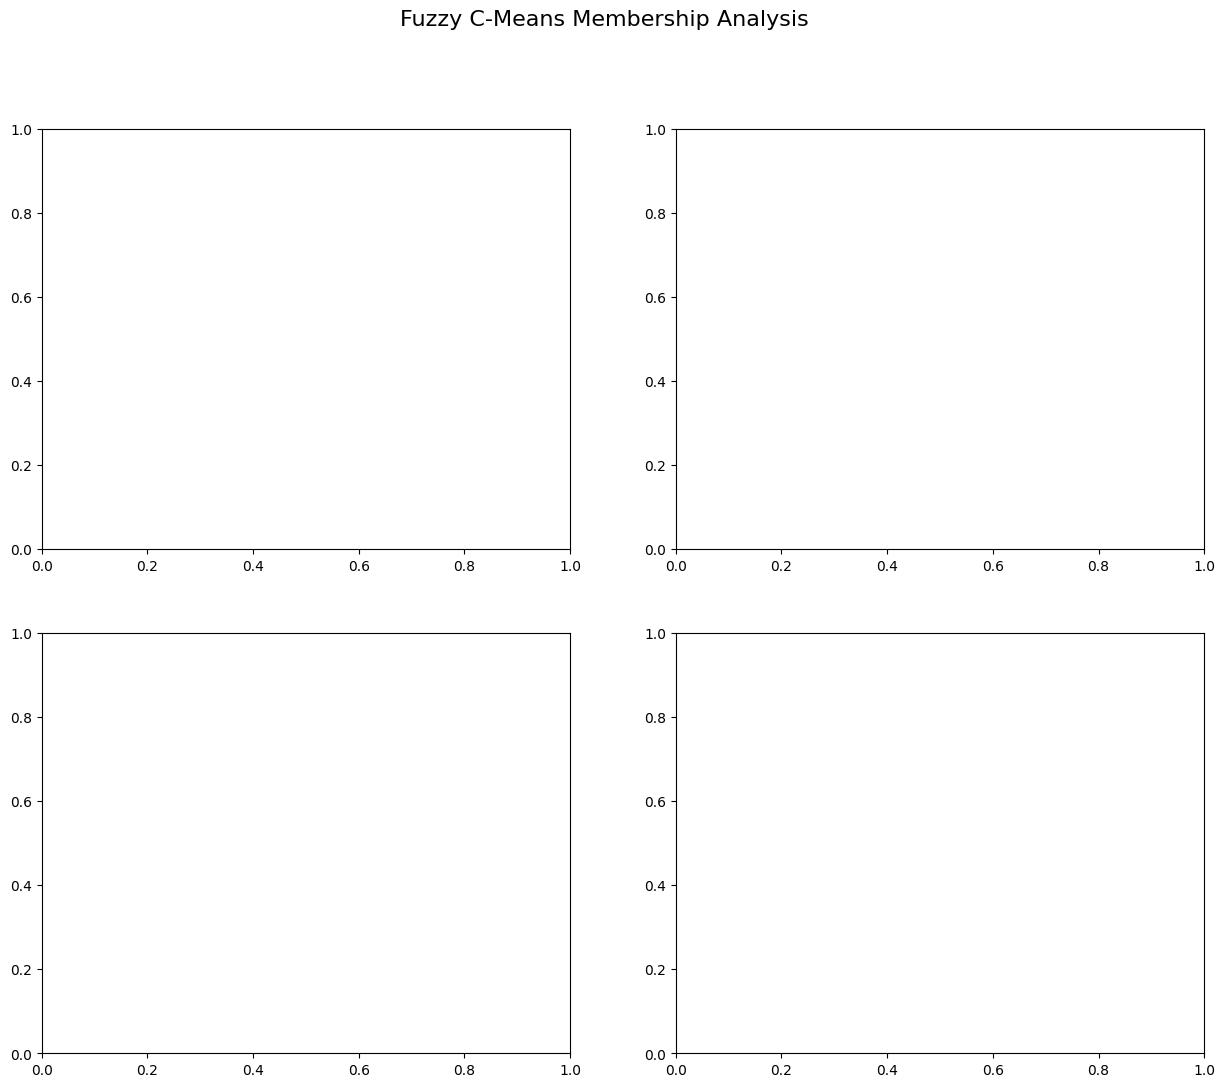

In [43]:
def perform_fcm_clustering_with_umap(X, n_clusters=4, random_state=42, m=2.0):
    """
    Perform Fuzzy C-Means clustering and visualize with UMAP 3D reduction.
    
    Parameters:
    -----------
    X : pd.DataFrame or np.array
        Feature matrix
    n_clusters : int
        Number of clusters for FCM
    random_state : int
        Random state for reproducibility
    m : float
        Fuzziness parameter (higher = more fuzzy)
        
    Returns:
    --------
    dict : Dictionary containing FCM results and UMAP coordinates
    """
    print(f"🔮 Performing Fuzzy C-Means clustering (k={n_clusters}) with UMAP 3D visualization...")
    
    # Prepare data - ensure numerical and no missing values
    X_clean = X.select_dtypes(include=[np.number]).fillna(X.select_dtypes(include=[np.number]).median())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    # Perform UMAP dimensionality reduction to 3D (for visualization)
    print("   📊 Applying UMAP dimensionality reduction to 3D...")
    umap_3d = umap.UMAP(n_components=3, random_state=random_state, n_neighbors=15, min_dist=0.1)
    X_umap_3d = umap_3d.fit_transform(X_scaled)
    
    # Perform Fuzzy C-Means clustering on original scaled data
    print("   🎯 Running Fuzzy C-Means clustering...")
    # Note: cmeans expects data in shape (n_features, n_samples)
    X_scaled_T = X_scaled.T
    
    # Run FCM
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_scaled_T, 
        n_clusters, 
        m, 
        error=0.005, 
        maxiter=1000, 
        init=None,
        seed=random_state
    )
    
    # Get hard cluster assignments (highest membership)
    cluster_labels = np.argmax(u, axis=0)
    
    # Create 3D visualization with membership probabilities
    print("   🎨 Creating 3D visualization with membership probabilities...")
    
    # Create color palette for clusters
    colors = px.colors.qualitative.Set3[:n_clusters]
    
    # Create multiple figures for different visualizations
    
    # Figure 1: Hard cluster assignments
    fig1 = go.Figure()
    
    for i in range(n_clusters):
        cluster_mask = cluster_labels == i
        fig1.add_trace(go.Scatter3d(
            x=X_umap_3d[cluster_mask, 0],
            y=X_umap_3d[cluster_mask, 1],
            z=X_umap_3d[cluster_mask, 2],
            mode='markers',
            marker=dict(
                size=6,
                color=colors[i],
                opacity=0.7
            ),
            name=f'Cluster {i+1}',
            text=[f'Cluster {i+1}<br>Point {j}<br>Max Membership: {u[i,j]:.3f}' 
                  for j in np.where(cluster_mask)[0]],
            hovertemplate='<b>%{text}</b><br>' +
                         'UMAP X: %{x:.2f}<br>' +
                         'UMAP Y: %{y:.2f}<br>' +
                         'UMAP Z: %{z:.2f}<extra></extra>'
        ))
    
    fig1.update_layout(
        title='FCM Clusters (Hard Assignment)',
        scene=dict(
            xaxis_title='UMAP Dim 1',
            yaxis_title='UMAP Dim 2',
            zaxis_title='UMAP Dim 3'
        ),
        width=800,
        height=600
    )
    fig1.show()
    
    # Figure 2: Membership strength visualization with individual points
    fig2 = go.Figure()
    max_memberships = np.max(u, axis=0)
    
    for i in range(n_clusters):
        cluster_mask = cluster_labels == i
        cluster_indices = np.where(cluster_mask)[0]
        
        # Create arrays for this cluster's points
        x_coords = X_umap_3d[cluster_mask, 0]
        y_coords = X_umap_3d[cluster_mask, 1]
        z_coords = X_umap_3d[cluster_mask, 2]
        cluster_memberships = max_memberships[cluster_mask]
        
        # Add trace for this cluster
        fig2.add_trace(go.Scatter3d(
            x=x_coords,
            y=y_coords,
            z=z_coords,
            mode='markers',
            marker=dict(
                size=cluster_memberships * 15 + 3,  # Scale size by membership
                color=colors[i],
                opacity=0.8,  # Fixed opacity
                line=dict(width=1, color='black')
            ),
            name=f'Cluster {i+1}',
            text=[f'Cluster {i+1}<br>Point {idx}<br>Membership: {max_memberships[idx]:.3f}' 
                  for idx in cluster_indices],
            hovertemplate='<b>%{text}</b><br>' +
                         'UMAP X: %{x:.2f}<br>' +
                         'UMAP Y: %{y:.2f}<br>' +
                         'UMAP Z: %{z:.2f}<extra></extra>'
        ))
    
    fig2.update_layout(
        title='FCM Clusters (Membership Strength)',
        scene=dict(
            xaxis_title='UMAP Dim 1',
            yaxis_title='UMAP Dim 2',
            zaxis_title='UMAP Dim 3'
        ),
        width=800,
        height=600
    )
    fig2.show()
    
    # Create membership probability plots using matplotlib
    print("   📊 Creating membership probability analysis...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Fuzzy C-Means Membership Analysis', fontsize=16)
    
    # Plot 1: Membership probability distribution
    for i in range(n_clusters):
        axes[0, 0].hist(u[i, :], bins=20, alpha=0.7, label=f'Cluster {i+1}', 
                       color=colors[i], density=True)
    axes[0, 0].set_title('Membership Probability Distribution')
    axes[0, 0].set_xlabel('Membership Probability')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Max membership distribution
    axes[0, 1].hist(max_memberships, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, 1].set_title('Maximum Membership Distribution')
    axes[0, 1].set_xlabel('Maximum Membership Probability')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Distance to cluster centers (sample)
    sample_indices = np.random.choice(len(cluster_labels), min(100, len(cluster_labels)), replace=False)
    for i in range(n_clusters):
        axes[1, 0].scatter(sample_indices, d[i, sample_indices], 
                          alpha=0.7, label=f'Center {i+1}', color=colors[i])
    axes[1, 0].set_title('Distance to Cluster Centers (Sample)')
    axes[1, 0].set_xlabel('Sample Index')
    axes[1, 0].set_ylabel('Distance')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Cluster assignment confidence
    entropy = -np.sum(u * np.log(u + 1e-10), axis=0)
    axes[1, 1].hist(entropy, bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].set_title('Prediction Entropy (Uncertainty)')
    axes[1, 1].set_xlabel('Entropy')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create membership probability heatmap
    print("   🔥 Creating membership probability heatmap...")
    
    # Select a sample of points for visualization
    sample_size = min(50, len(cluster_labels))
    sample_indices = np.random.choice(len(cluster_labels), sample_size, replace=False)
    
    plt.figure(figsize=(12, 8))
    
    # Create heatmap of membership probabilities
    membership_sample = u[:, sample_indices]
    sns.heatmap(
        membership_sample, 
        annot=True, 
        fmt='.2f', 
        cmap='viridis',
        xticklabels=[f'Point {i}' for i in sample_indices],
        yticklabels=[f'Cluster {i+1}' for i in range(n_clusters)],
        cbar_kws={'label': 'Membership Probability'}
    )
    plt.title(f'FCM Membership Probabilities (Sample of {sample_size} points)')
    plt.xlabel('Data Points')
    plt.ylabel('Clusters')
    plt.tight_layout()
    plt.show()
    
    # Calculate FCM statistics
    fcm_stats = {
        'fpc': fpc,  # Fuzzy Partition Coefficient
        'n_clusters': n_clusters,
        'n_points': len(cluster_labels),
        'avg_max_membership': np.mean(np.max(u, axis=0)),
        'cluster_sizes': [np.sum(cluster_labels == i) for i in range(n_clusters)]
    }
    
    # Print FCM summary
    print(f"\n=== Fuzzy C-Means Clustering Results ===")
    print(f"Number of clusters: {n_clusters}")
    print(f"Total data points: {len(cluster_labels)}")
    print(f"Fuzzy Partition Coefficient (FPC): {fpc:.4f}")
    print(f"Average maximum membership: {fcm_stats['avg_max_membership']:.4f}")
    print(f"Objective function value: {jm[-1]:.4f}")
    
    for i, size in enumerate(fcm_stats['cluster_sizes']):
        percentage = size / len(cluster_labels) * 100
        print(f"Cluster {i+1}: {size} points ({percentage:.1f}%)")
    
    return {
        'cluster_labels': cluster_labels,
        'membership_matrix': u,
        'cluster_centers': cntr,
        'umap_coordinates': X_umap_3d,
        'umap_model': umap_3d,
        'scaler': scaler,
        'fcm_stats': fcm_stats,
        'distances': d,
        'X_scaled': X_scaled
    }

# Apply FCM clustering with UMAP
if 'X_ml' in locals():
    fcm_results = perform_fcm_clustering_with_umap(X_ml, n_clusters=4, m=2.0)
    print("✅ Fuzzy C-Means clustering with UMAP completed successfully!")


Applying Genetic Algorithm Feature Selection to RFS
🧬 Implementing Genetic Algorithm Feature Selection for RFS...
   Generations: 30, Population: 30
   Crossover Prob: 0.8, Mutation Prob: 0.1
   K-Fold CV: 5
   📊 Dataset: 157 samples, 65 features
   🎯 Initializing population and starting evolution...
   🔄 Running evolution for 30 generations...
     Gen   0: Max Fitness = 0.5855, Avg Fitness = 0.5471, Std = 0.0241
     Gen  10: Max Fitness = 0.6171, Avg Fitness = 0.6140, Std = 0.0103
     Gen  20: Max Fitness = 0.6298, Avg Fitness = 0.6298, Std = 0.0000
     Gen  29: Max Fitness = 0.6298, Avg Fitness = 0.6298, Std = 0.0000

=== Genetic Algorithm Results for RFS ===
Best fitness (accuracy): 0.6298
Number of selected features: 29
Selected features: ['disease_state_at_transplant', 'degree_of_match', 'conditioning_regimen', 'thymo', 'steroids_for_gvhd_prophylaxis', 'bmi', 'cmv_treated', 'd30_cd3+', 'd60_cd3+', 'd60_cd3-', 'd100_cd3-', 'platelet_engraftment', 'mrd_status_day_30', 'mrd_stat

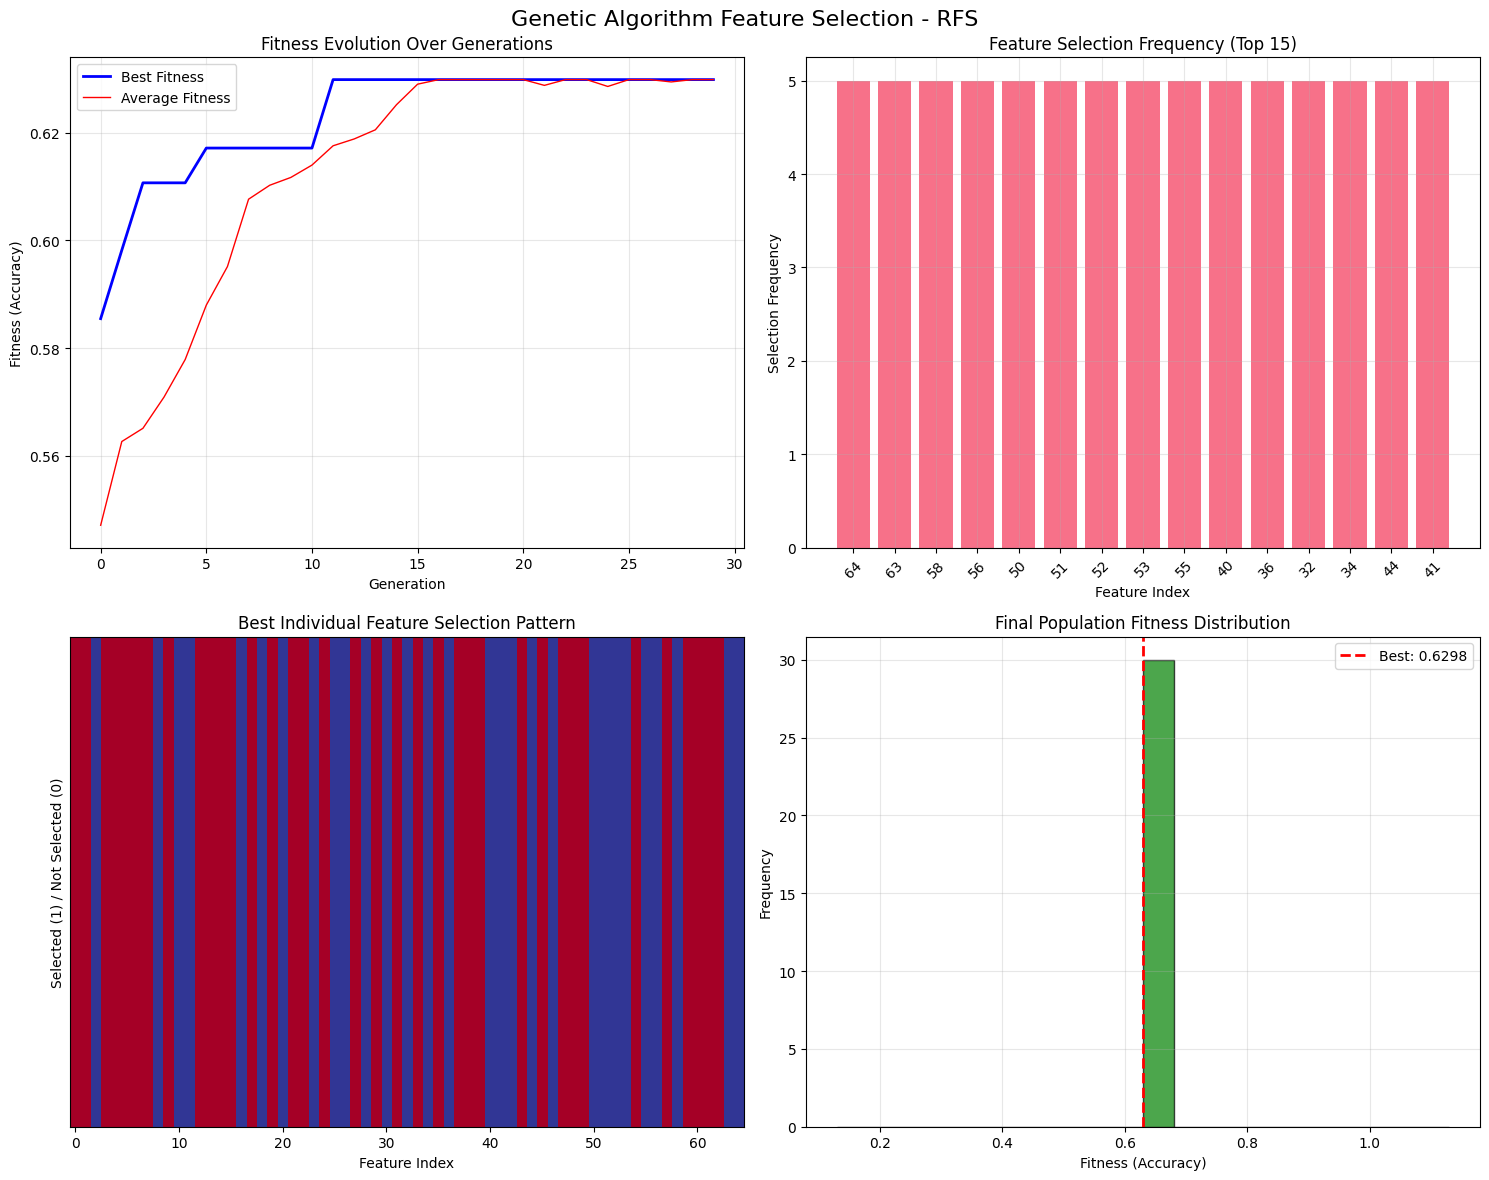

   🎯 Performing detailed K-Fold evaluation of best feature subset...

=== K-Fold Cross-Validation Results (k=5) ===
Individual fold accuracies: ['0.6562', '0.5938', '0.4516', '0.5161', '0.5806']
Mean accuracy: 0.5597 ± 0.0700
Best accuracy: 0.6562
Worst accuracy: 0.4516

=== Classification Report (Cross-Validation) ===
              precision    recall  f1-score   support

           0       0.58      0.68      0.63        85
           1       0.53      0.42      0.47        72

    accuracy                           0.56       157
   macro avg       0.55      0.55      0.55       157
weighted avg       0.56      0.56      0.55       157

   📊 Analyzing feature importance of selected features...

=== Feature Importance (Random Forest) ===
bmi                           : 0.0915
age_receiver_donor_ratio      : 0.0893
platelet_engraftment          : 0.0771
age_difference                : 0.0763
d(60-100)_cd3+                : 0.0564
d60_cd3+                      : 0.0517
pct_change_30_10

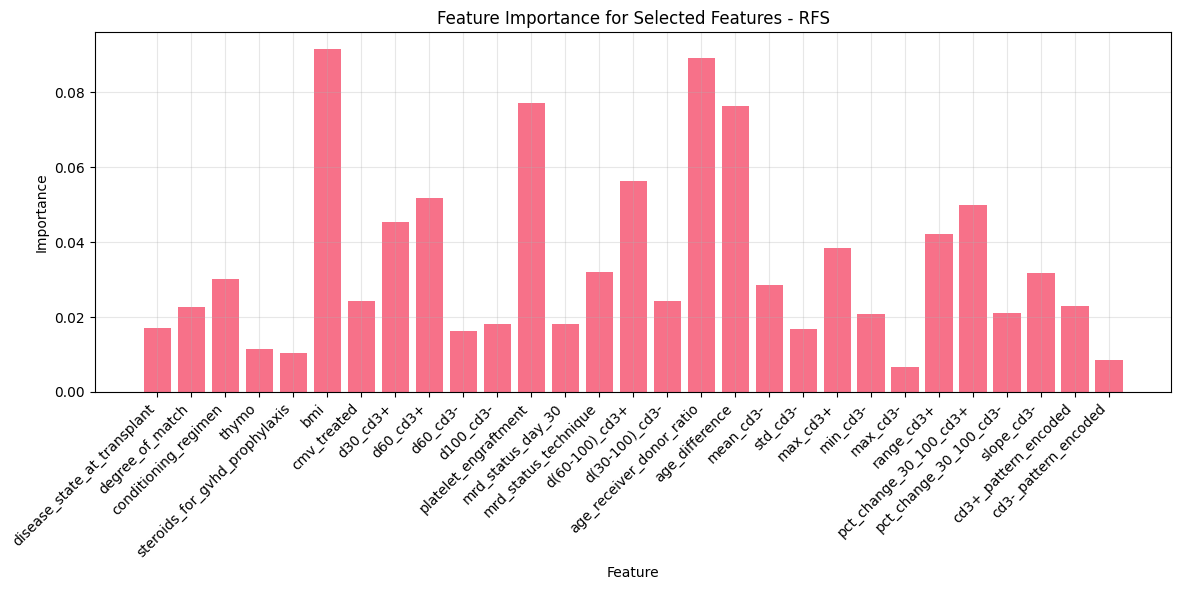

   🔄 Comparing with full feature set...

=== Comparison with Full Feature Set ===
Selected features (29): 0.5597 ± 0.0700
All features (65): 0.4839 ± 0.0392
Improvement: +0.0758
Feature reduction: 55.4%

Applying Genetic Algorithm Feature Selection to Death
🧬 Implementing Genetic Algorithm Feature Selection for Death...
   Generations: 30, Population: 30
   Crossover Prob: 0.8, Mutation Prob: 0.1
   K-Fold CV: 5
   📊 Dataset: 157 samples, 65 features
   🎯 Initializing population and starting evolution...
   🔄 Running evolution for 30 generations...
     Gen   0: Max Fitness = 0.7069, Avg Fitness = 0.6810, Std = 0.0133
     Gen  10: Max Fitness = 0.7198, Avg Fitness = 0.7191, Std = 0.0019
     Gen  20: Max Fitness = 0.7198, Avg Fitness = 0.7198, Std = 0.0000
     Gen  29: Max Fitness = 0.7198, Avg Fitness = 0.7198, Std = 0.0000

=== Genetic Algorithm Results for Death ===
Best fitness (accuracy): 0.7198
Number of selected features: 30
Selected features: ['disease_state_at_transplant', '

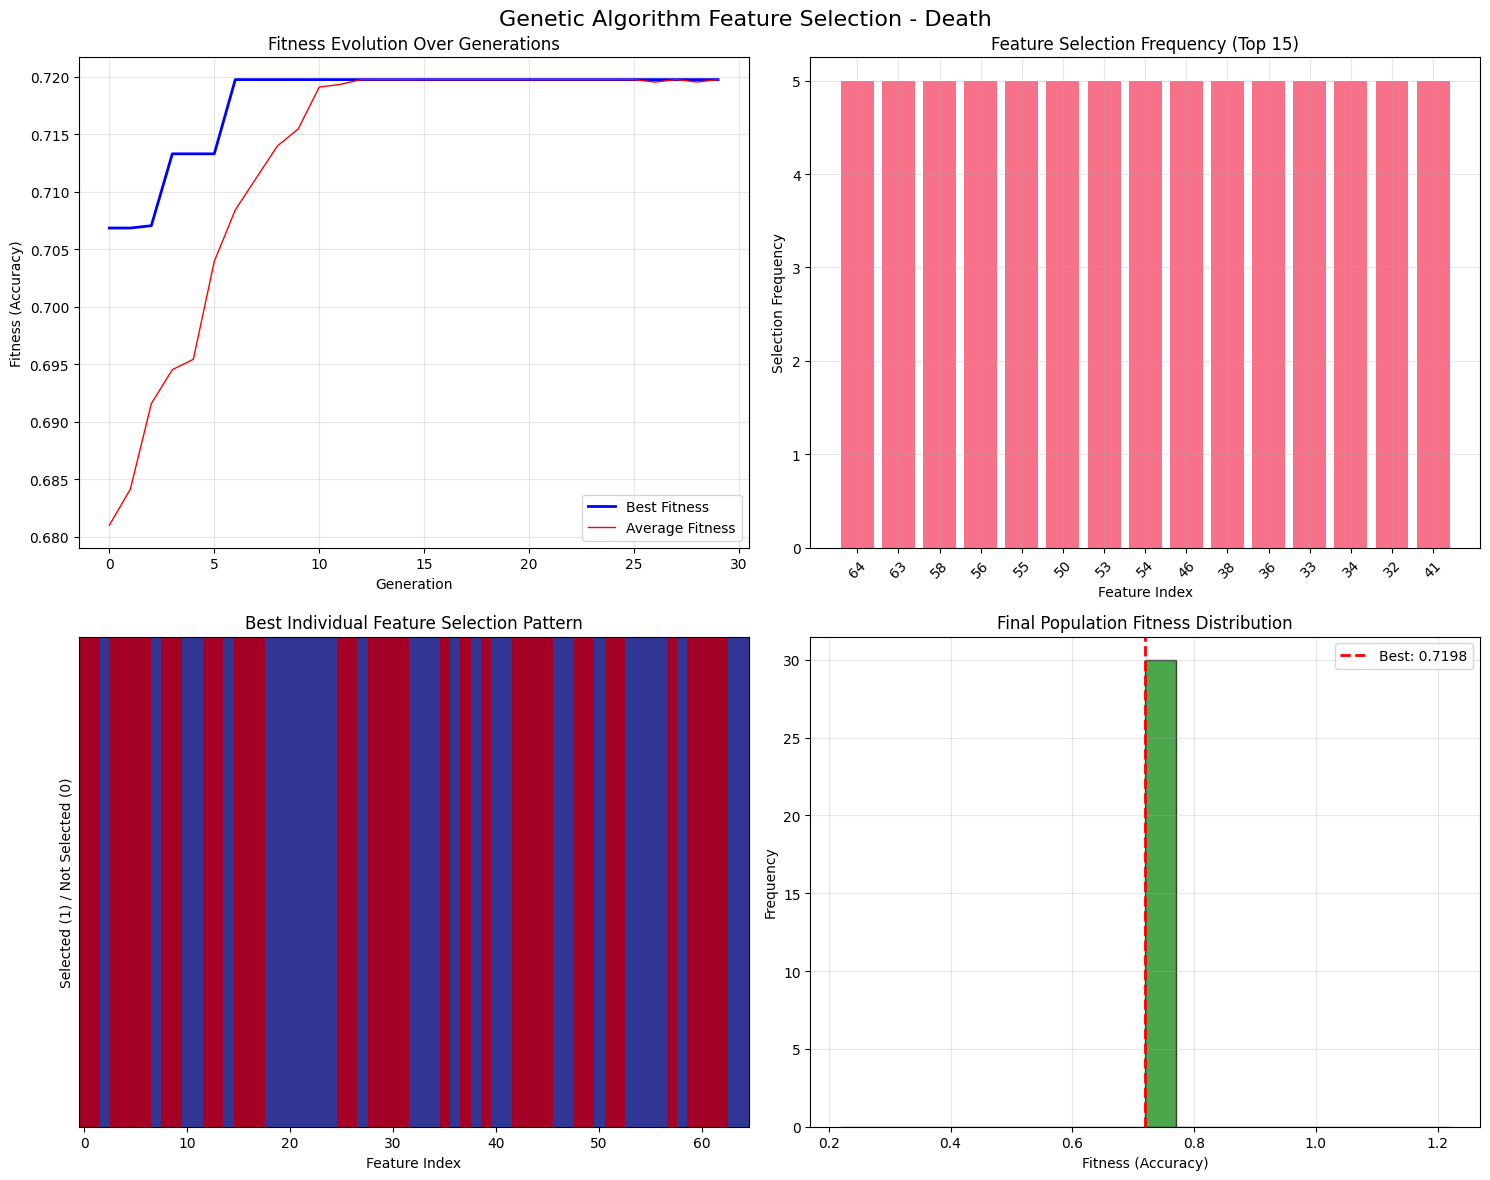

   🎯 Performing detailed K-Fold evaluation of best feature subset...

=== K-Fold Cross-Validation Results (k=5) ===
Individual fold accuracies: ['0.6875', '0.7812', '0.7097', '0.6774', '0.6452']
Mean accuracy: 0.7002 ± 0.0455
Best accuracy: 0.7812
Worst accuracy: 0.6452

=== Classification Report (Cross-Validation) ===
              precision    recall  f1-score   support

           0       0.70      0.95      0.80       102
           1       0.72      0.24      0.36        55

    accuracy                           0.70       157
   macro avg       0.71      0.59      0.58       157
weighted avg       0.71      0.70      0.65       157

   📊 Analyzing feature importance of selected features...

=== Feature Importance (Random Forest) ===
bmi                           : 0.0896
age_receiver_donor_ratio      : 0.0827
cv_cd3+                       : 0.0620
d(60-100)_cd3+                : 0.0566
range_cd3+                    : 0.0492
pct_change_30_100_cd3+        : 0.0485
max_cd3+        

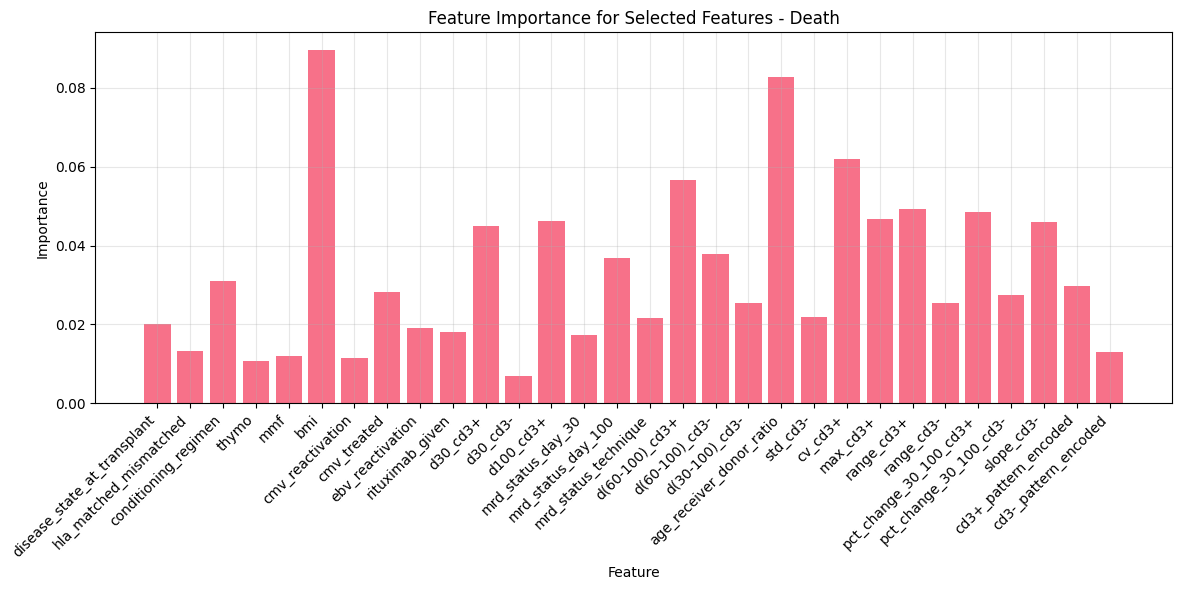

   🔄 Comparing with full feature set...

=== Comparison with Full Feature Set ===
Selected features (30): 0.7002 ± 0.0455
All features (65): 0.6752 ± 0.0228
Improvement: +0.0250
Feature reduction: 53.8%

Applying Genetic Algorithm Feature Selection to Relapse
🧬 Implementing Genetic Algorithm Feature Selection for Relapse...
   Generations: 30, Population: 30
   Crossover Prob: 0.8, Mutation Prob: 0.1
   K-Fold CV: 5
   📊 Dataset: 157 samples, 65 features
   🎯 Initializing population and starting evolution...
   🔄 Running evolution for 30 generations...
     Gen   0: Max Fitness = 0.7198, Avg Fitness = 0.7034, Std = 0.0081
     Gen  10: Max Fitness = 0.7198, Avg Fitness = 0.7198, Std = 0.0000
     Gen  20: Max Fitness = 0.7198, Avg Fitness = 0.7198, Std = 0.0000
     Gen  29: Max Fitness = 0.7198, Avg Fitness = 0.7198, Std = 0.0000

=== Genetic Algorithm Results for Relapse ===
Best fitness (accuracy): 0.7198
Number of selected features: 33
Selected features: ['age', 'disease_state_at_t

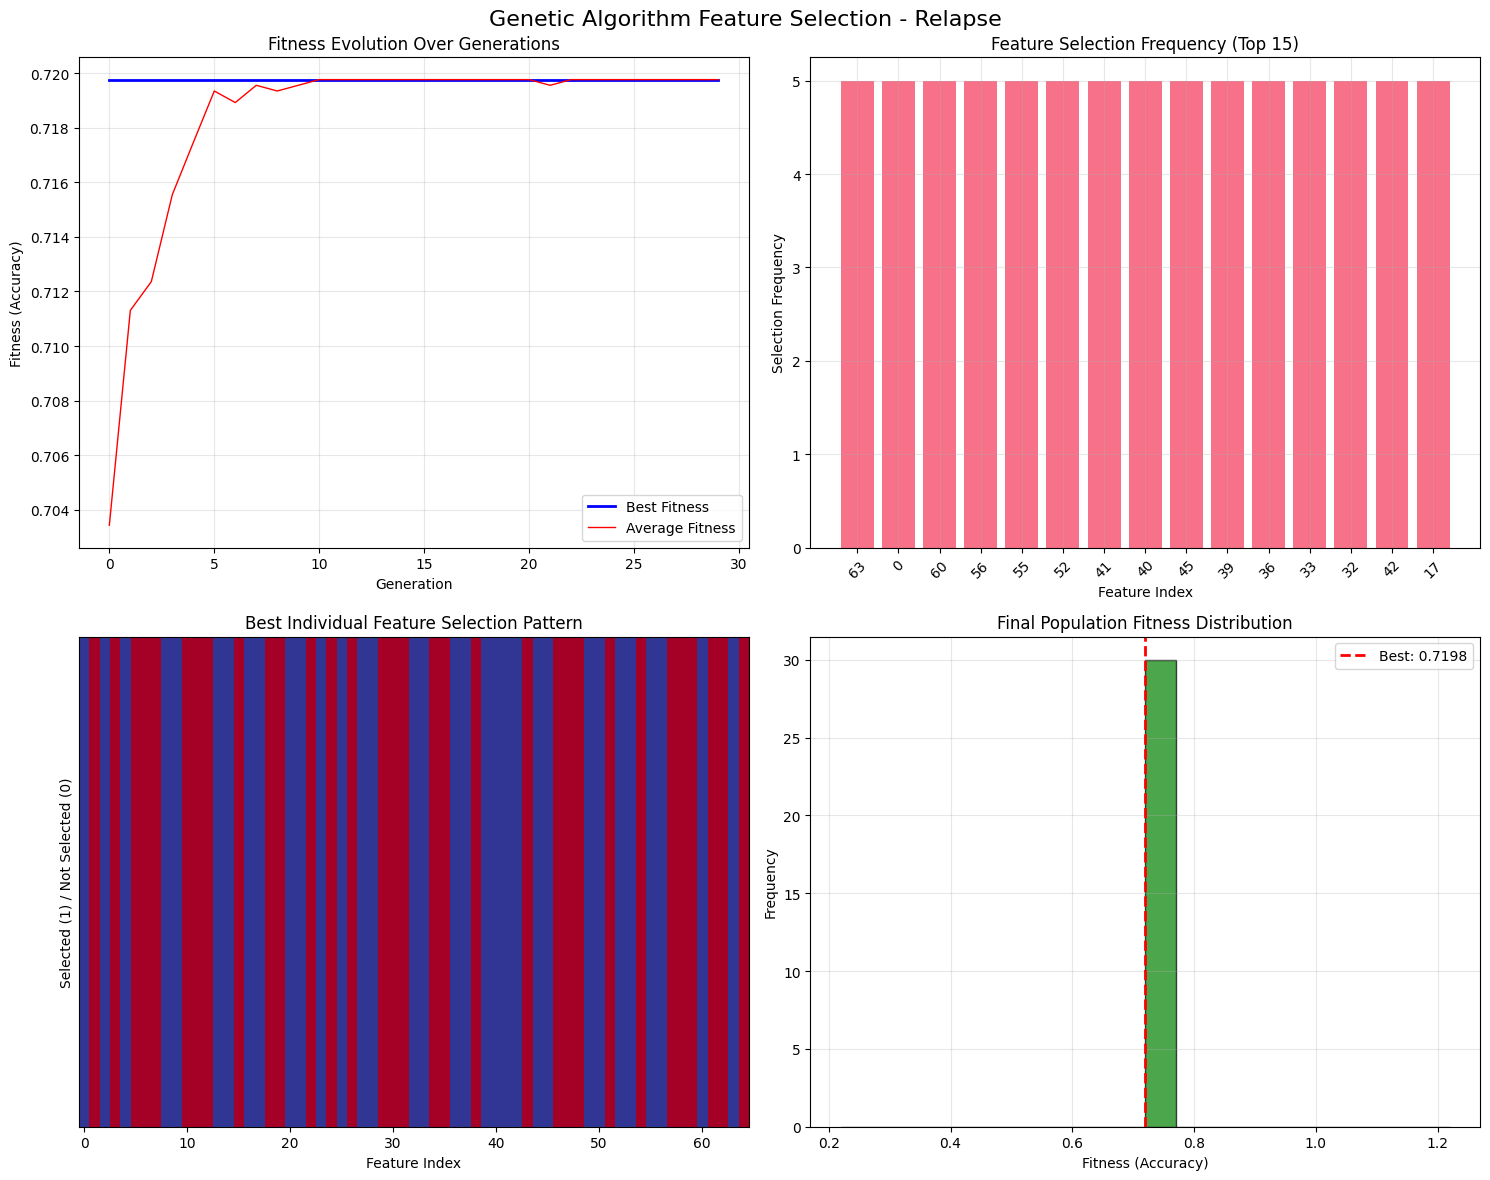

   🎯 Performing detailed K-Fold evaluation of best feature subset...

=== K-Fold Cross-Validation Results (k=5) ===
Individual fold accuracies: ['0.7500', '0.6875', '0.8387', '0.6774', '0.6452']
Mean accuracy: 0.7198 ± 0.0685
Best accuracy: 0.8387
Worst accuracy: 0.6452

=== Classification Report (Cross-Validation) ===
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       109
           1       1.00      0.08      0.15        48

    accuracy                           0.72       157
   macro avg       0.86      0.54      0.49       157
weighted avg       0.80      0.72      0.62       157

   📊 Analyzing feature importance of selected features...

=== Feature Importance (Random Forest) ===
age                           : 0.1011
age_difference                : 0.0810
age_receiver_donor_ratio      : 0.0771
d(60-100)_cd3+                : 0.0661
min_cd3+                      : 0.0524
range_cd3+                    : 0.0482
d100_cd3+       

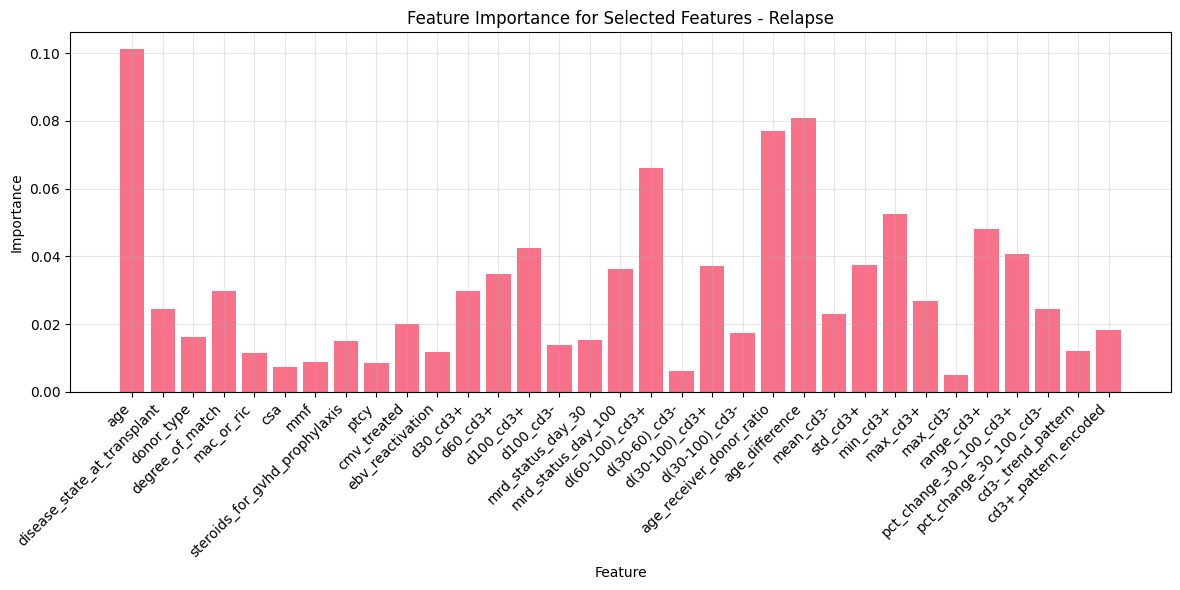

   🔄 Comparing with full feature set...

=== Comparison with Full Feature Set ===
Selected features (33): 0.7198 ± 0.0685
All features (65): 0.6944 ± 0.0130
Improvement: +0.0254
Feature reduction: 49.2%
✅ Genetic Algorithm Feature Selection completed successfully!


In [44]:
def implement_genetic_algorithm_feature_selection(X, y, target_name='Target', 
                                                  n_generations=50, population_size=50, 
                                                  crossover_prob=0.8, mutation_prob=0.1,
                                                  k_folds=5, random_state=42):
    """
    Implement Genetic Algorithm for feature selection with K-Fold SVM evaluation.
    
    Parameters:
    -----------
    X : pd.DataFrame or np.array
        Feature matrix
    y : pd.Series or np.array
        Target variable
    target_name : str
        Name of the target variable
    n_generations : int
        Number of generations for GA
    population_size : int
        Size of population in each generation
    crossover_prob : float
        Probability of crossover
    mutation_prob : float
        Probability of mutation
    k_folds : int
        Number of folds for cross-validation
    random_state : int
        Random state for reproducibility
        
    Returns:
    --------
    dict : Dictionary containing GA results and best features
    """
    print(f"🧬 Implementing Genetic Algorithm Feature Selection for {target_name}...")
    print(f"   Generations: {n_generations}, Population: {population_size}")
    print(f"   Crossover Prob: {crossover_prob}, Mutation Prob: {mutation_prob}")
    print(f"   K-Fold CV: {k_folds}")
    
    # Prepare data
    X_clean = X.select_dtypes(include=[np.number]).fillna(X.select_dtypes(include=[np.number]).median())
    y_clean = y.dropna()
    
    # Align X and y
    common_indices = X_clean.index.intersection(y_clean.index)
    X_aligned = X_clean.loc[common_indices]
    y_aligned = y_clean.loc[common_indices]
    
    if len(y_aligned.unique()) < 2:
        print(f"⚠️ Insufficient classes for classification ({len(y_aligned.unique())} unique values)")
        return None
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_aligned)
    
    # Get feature names
    feature_names = X_aligned.columns.tolist() if hasattr(X_aligned, 'columns') else [f'Feature_{i}' for i in range(X_scaled.shape[1])]
    n_features = len(feature_names)
    
    print(f"   📊 Dataset: {X_scaled.shape[0]} samples, {n_features} features")
    
    # Set random seeds
    random.seed(random_state)
    np.random.seed(random_state)
    
    # Define DEAP GA components
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize accuracy
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    toolbox = base.Toolbox()
    
    # Attribute generator - binary encoding for feature selection
    toolbox.register("attr_bool", random.randint, 0, 1)
    
    # Structure initializers
    toolbox.register("individual", tools.initRepeat, creator.Individual, 
                    toolbox.attr_bool, n_features)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    # Fitness function using K-Fold SVM
    def evaluate_feature_subset(individual):
        """
        Evaluate fitness of feature subset using K-Fold Cross-Validation with SVM.
        """
        # Convert binary individual to feature indices
        selected_features = [i for i, bit in enumerate(individual) if bit == 1]
        
        # Ensure at least one feature is selected
        if len(selected_features) == 0:
            return (0.0,)  # Return 0 fitness for empty feature set
        
        # Select features
        X_subset = X_scaled[:, selected_features]
        
        try:
            # Perform K-Fold Cross-Validation with SVM
            svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=random_state)
            cv_scores = cross_val_score(svm_classifier, X_subset, y_aligned, 
                                      cv=k_folds, scoring='accuracy', n_jobs=1)
            
            # Return mean accuracy as fitness
            fitness = np.mean(cv_scores)
            return (fitness,)
            
        except Exception as e:
            # Return 0 fitness if evaluation fails
            return (0.0,)
    
    # Register genetic operators
    toolbox.register("evaluate", evaluate_feature_subset)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=mutation_prob/n_features)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    # Initialize population
    print("   🎯 Initializing population and starting evolution...")
    population = toolbox.population(n=population_size)
    
    # Track statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # Hall of Fame to track best individuals
    hof = tools.HallOfFame(5)
    
    # Evolution tracking
    fitness_history = []
    best_fitness_history = []
    avg_fitness_history = []
    
    # Evaluate initial population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    
    hof.update(population)
    
    # Evolution loop
    print(f"   🔄 Running evolution for {n_generations} generations...")
    
    for generation in range(n_generations):
        # Selection
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))
        
        # Crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < crossover_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        
        # Mutation
        for mutant in offspring:
            if random.random() < mutation_prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        # Evaluate invalid individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # Replace population
        population[:] = offspring
        
        # Update hall of fame
        hof.update(population)
        
        # Record statistics
        record = stats.compile(population)
        fitness_history.append(record)
        best_fitness_history.append(record['max'])
        avg_fitness_history.append(record['avg'])
        
        # Print progress
        if generation % 10 == 0 or generation == n_generations - 1:
            print(f"     Gen {generation:3d}: Max Fitness = {record['max']:.4f}, "
                  f"Avg Fitness = {record['avg']:.4f}, Std = {record['std']:.4f}")
    
    # Get best individual
    best_individual = hof[0]
    best_features_indices = [i for i, bit in enumerate(best_individual) if bit == 1]
    best_features_names = [feature_names[i] for i in best_features_indices]
    best_fitness = best_individual.fitness.values[0]
    
    print(f"\n=== Genetic Algorithm Results for {target_name} ===")
    print(f"Best fitness (accuracy): {best_fitness:.4f}")
    print(f"Number of selected features: {len(best_features_indices)}")
    print(f"Selected features: {best_features_names}")
    
    # Visualize GA progress
    print("   📈 Creating evolution progress visualization...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Genetic Algorithm Feature Selection - {target_name}', fontsize=16)
    
    # Plot 1: Fitness evolution
    generations = range(len(best_fitness_history))
    axes[0, 0].plot(generations, best_fitness_history, 'b-', label='Best Fitness', linewidth=2)
    axes[0, 0].plot(generations, avg_fitness_history, 'r-', label='Average Fitness', linewidth=1)
    axes[0, 0].set_title('Fitness Evolution Over Generations')
    axes[0, 0].set_xlabel('Generation')
    axes[0, 0].set_ylabel('Fitness (Accuracy)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Feature selection frequency
    feature_selection_freq = np.zeros(n_features)
    for individual in hof:
        for i, bit in enumerate(individual):
            if bit == 1:
                feature_selection_freq[i] += 1
    
    # Sort features by selection frequency
    sorted_indices = np.argsort(feature_selection_freq)[::-1]
    top_15_indices = sorted_indices[:15]  # Show top 15 features
    
    axes[0, 1].bar(range(len(top_15_indices)), feature_selection_freq[top_15_indices])
    axes[0, 1].set_title('Feature Selection Frequency (Top 15)')
    axes[0, 1].set_xlabel('Feature Index')
    axes[0, 1].set_ylabel('Selection Frequency')
    axes[0, 1].set_xticks(range(len(top_15_indices)))
    axes[0, 1].set_xticklabels([str(i) for i in top_15_indices], rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Best individual feature map
    axes[1, 0].imshow(np.array(best_individual).reshape(1, -1), cmap='RdYlBu', aspect='auto')
    axes[1, 0].set_title('Best Individual Feature Selection Pattern')
    axes[1, 0].set_xlabel('Feature Index')
    axes[1, 0].set_ylabel('Selected (1) / Not Selected (0)')
    axes[1, 0].set_yticks([])
    
    # Plot 4: Fitness distribution in final population
    final_fitnesses = [ind.fitness.values[0] for ind in population]
    axes[1, 1].hist(final_fitnesses, bins=20, alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].axvline(best_fitness, color='red', linestyle='--', linewidth=2, label=f'Best: {best_fitness:.4f}')
    axes[1, 1].set_title('Final Population Fitness Distribution')
    axes[1, 1].set_xlabel('Fitness (Accuracy)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Detailed evaluation of best feature subset
    print("   🎯 Performing detailed K-Fold evaluation of best feature subset...")
    
    X_best = X_scaled[:, best_features_indices]
    
    # Detailed K-Fold evaluation
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    svm_best = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=random_state)
    
    # Get detailed CV results
    cv_scores = cross_val_score(svm_best, X_best, y_aligned, cv=kfold, scoring='accuracy')
    cv_predictions = cross_val_predict(svm_best, X_best, y_aligned, cv=kfold)
    
    print(f"\n=== K-Fold Cross-Validation Results (k={k_folds}) ===")
    print(f"Individual fold accuracies: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"Mean accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    print(f"Best accuracy: {np.max(cv_scores):.4f}")
    print(f"Worst accuracy: {np.min(cv_scores):.4f}")
    
    # Classification report
    print(f"\n=== Classification Report (Cross-Validation) ===")
    print(classification_report(y_aligned, cv_predictions))
    
    # Feature importance analysis
    print("   📊 Analyzing feature importance of selected features...")
    
    # Train final model and get feature importance (if possible)
    try:
        # Use Random Forest to get feature importance for selected features
        rf_importance = RandomForestClassifier(n_estimators=100, random_state=random_state)
        rf_importance.fit(X_best, y_aligned)
        importances = rf_importance.feature_importances_
        
        # Create feature importance DataFrame
        importance_df = pd.DataFrame({
            'Feature': best_features_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print(f"\n=== Feature Importance (Random Forest) ===")
        for _, row in importance_df.iterrows():
            print(f"{row['Feature']:30s}: {row['Importance']:.4f}")
        
        # Plot feature importance
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(best_features_names)), importances)
        plt.title(f'Feature Importance for Selected Features - {target_name}')
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.xticks(range(len(best_features_names)), best_features_names, rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Could not compute feature importance: {str(e)}")
        importance_df = None
    
    # Compare with all features
    print("   🔄 Comparing with full feature set...")
    svm_full = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=random_state)
    cv_scores_full = cross_val_score(svm_full, X_scaled, y_aligned, cv=k_folds, scoring='accuracy')
    
    print(f"\n=== Comparison with Full Feature Set ===")
    print(f"Selected features ({len(best_features_indices)}): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    print(f"All features ({n_features}): {np.mean(cv_scores_full):.4f} ± {np.std(cv_scores_full):.4f}")
    improvement = np.mean(cv_scores) - np.mean(cv_scores_full)
    print(f"Improvement: {improvement:+.4f}")
    print(f"Feature reduction: {((n_features - len(best_features_indices)) / n_features * 100):.1f}%")
    
    return {
        'best_individual': best_individual,
        'best_features_indices': best_features_indices,
        'best_features_names': best_features_names,
        'best_fitness': best_fitness,
        'cv_scores': cv_scores,
        'cv_scores_full': cv_scores_full,
        'fitness_history': fitness_history,
        'best_fitness_history': best_fitness_history,
        'avg_fitness_history': avg_fitness_history,
        'hall_of_fame': hof,
        'feature_selection_freq': feature_selection_freq,
        'scaler': scaler,
        'feature_names': feature_names,
        'importance_df': importance_df if 'importance_df' in locals() else None,
        'X_best': X_best,
        'n_generations': n_generations,
        'population_size': population_size
    }

# Apply Genetic Algorithm Feature Selection
if 'X_ml' in locals() and 'y_ml' in locals():
    ga_results = {}
    target_names = ['RFS', 'Death', 'Relapse']
    
    for i, target_name in enumerate(target_names):
        if i < len(y_ml.columns):
            target_col = y_ml.columns[i]
            print(f"\n{'='*70}")
            print(f"Applying Genetic Algorithm Feature Selection to {target_name}")
            print(f"{'='*70}")
            
            result = implement_genetic_algorithm_feature_selection(
                X_ml, y_ml[target_col], target_name, 
                n_generations=30,  # Reduced for demonstration
                population_size=30,
                k_folds=5
            )
            
            if result:
                ga_results[target_name] = result
    
    print("✅ Genetic Algorithm Feature Selection completed successfully!")

## 12. Genetic Algorithm for Feature Selection

### GA-based Feature Selection with K-Fold SVM Evaluation

Implement genetic algorithm to find optimal feature subsets using SVM accuracy as fitness function.


Applying Fuzzy SVM to RFS
🧠 Implementing Fuzzy SVM Classification for RFS...
   📊 Training set: 109 samples, Test set: 48 samples
   🎯 Training Fuzzy SVM classifier...
   ✅ Test Accuracy: 0.5417
   🎨 Creating probability distribution visualizations...


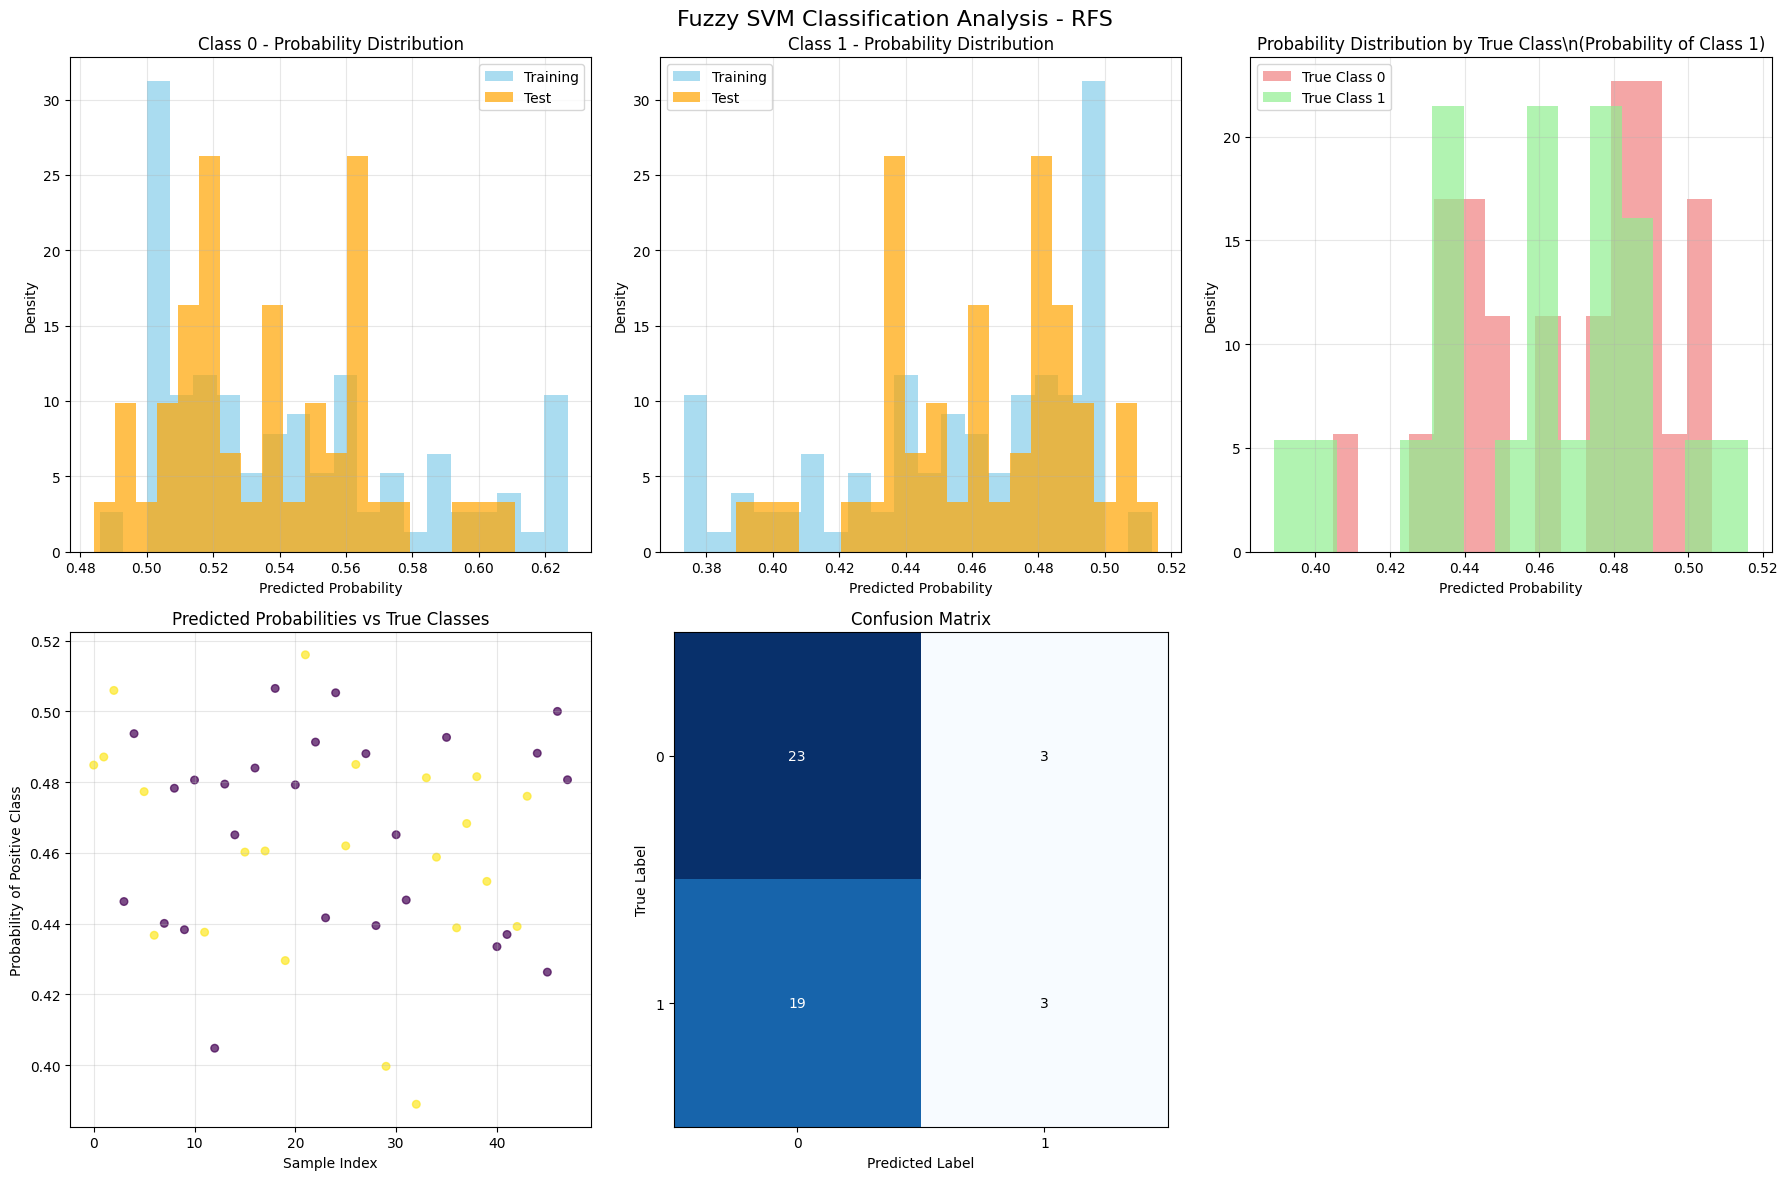

   📈 Creating detailed probability analysis...


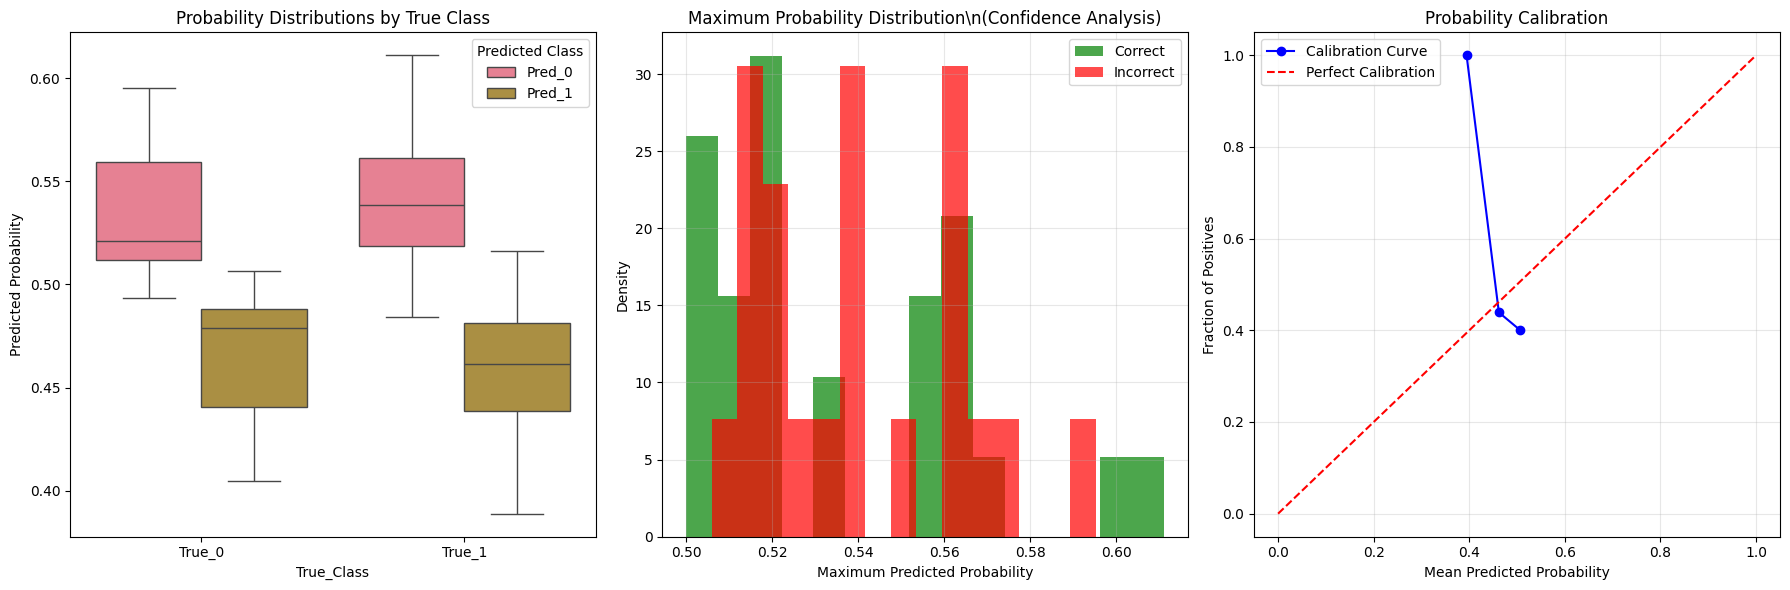


=== Fuzzy SVM Classification Results for RFS ===
Test Accuracy: 0.5417
Number of classes: 2
Class distribution in test set:
  Class 0: 26 samples (54.2%)
  Class 1: 22 samples (45.8%)

=== Classification Report ===
              precision    recall  f1-score   support

     Class_0       0.55      0.88      0.68        26
     Class_1       0.50      0.14      0.21        22

    accuracy                           0.54        48
   macro avg       0.52      0.51      0.45        48
weighted avg       0.53      0.54      0.46        48


=== Probability Statistics ===
Class 0 probabilities:
  Mean: 0.5363
  Std:  0.0290
  Min:  0.4840
  Max:  0.6111
Class 1 probabilities:
  Mean: 0.4637
  Std:  0.0290
  Min:  0.3889
  Max:  0.5160
Average maximum probability (confidence): 0.5377
Percentage of predictions with >0.8 confidence: 0.0%

Applying Fuzzy SVM to Death
🧠 Implementing Fuzzy SVM Classification for Death...
   📊 Training set: 109 samples, Test set: 48 samples
   🎯 Training Fuzzy SV

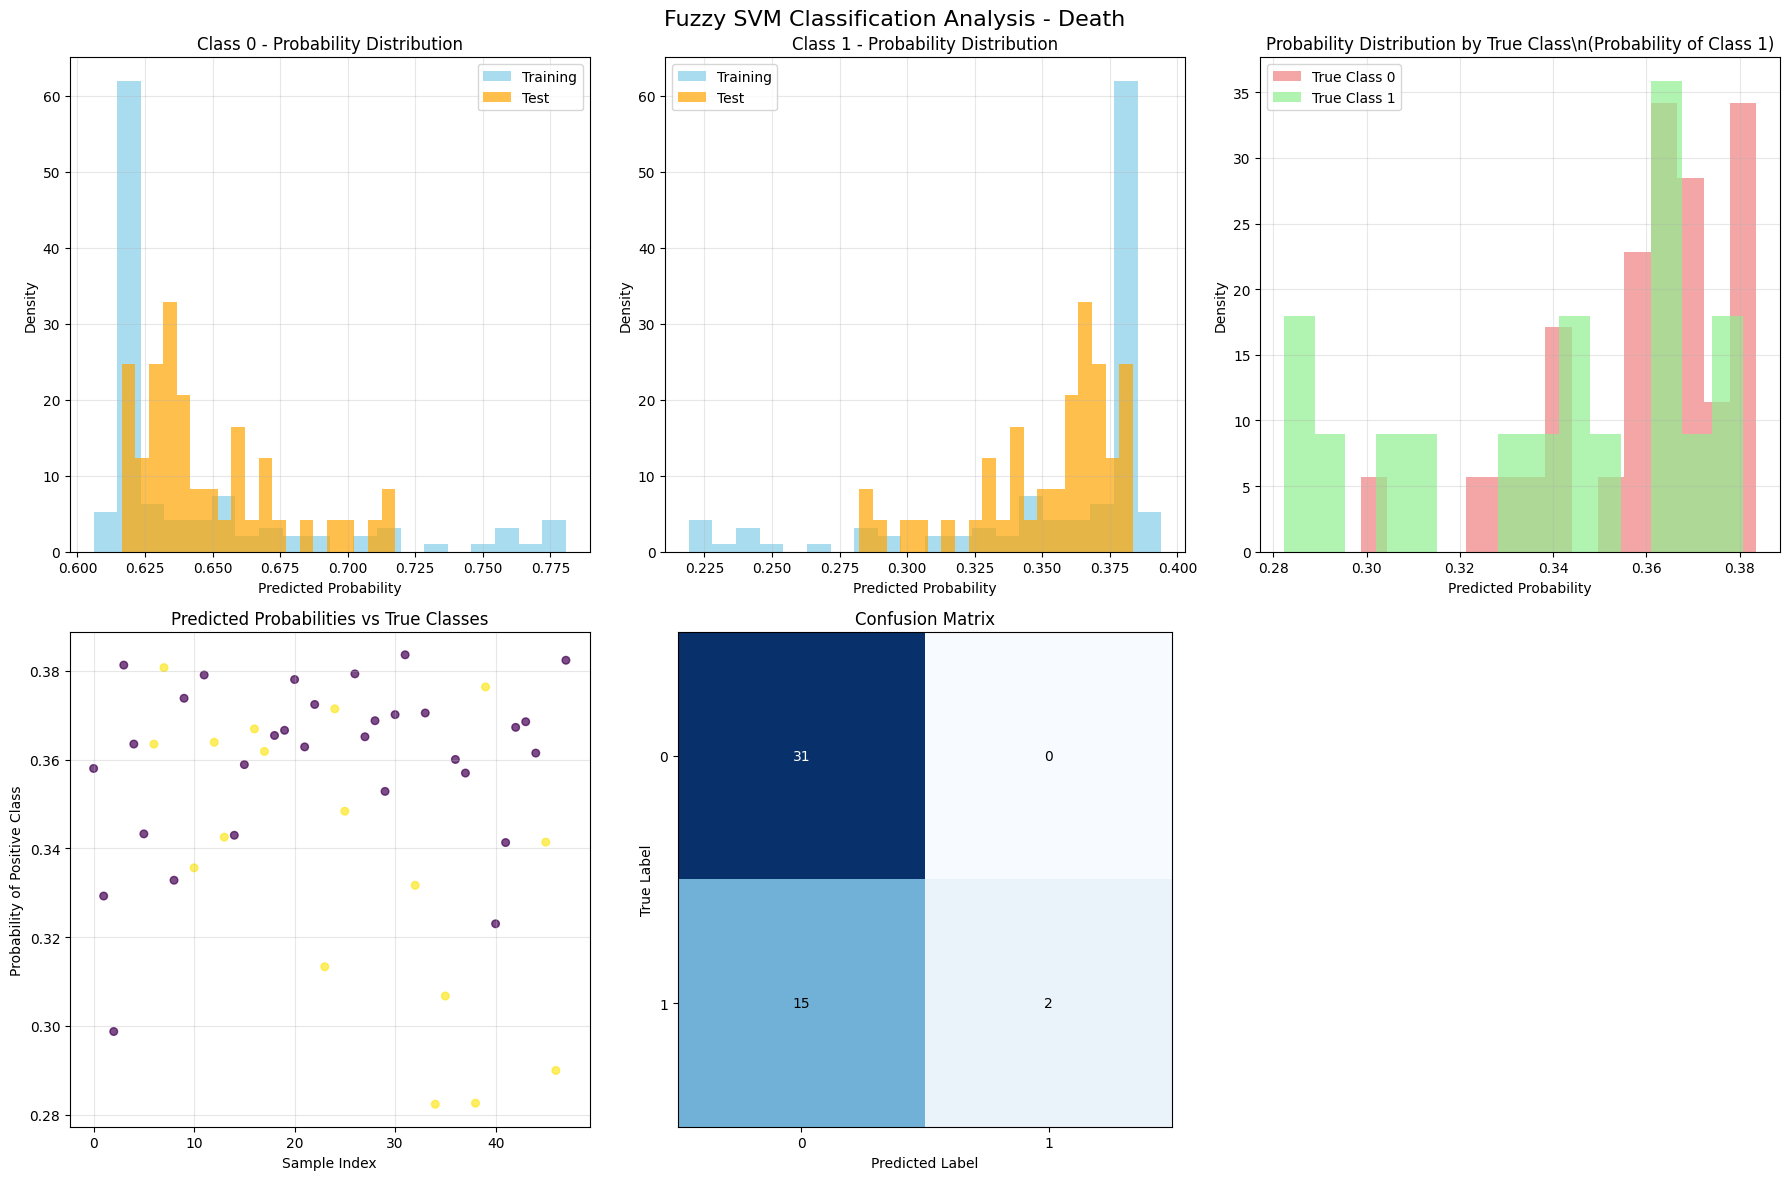

   📈 Creating detailed probability analysis...


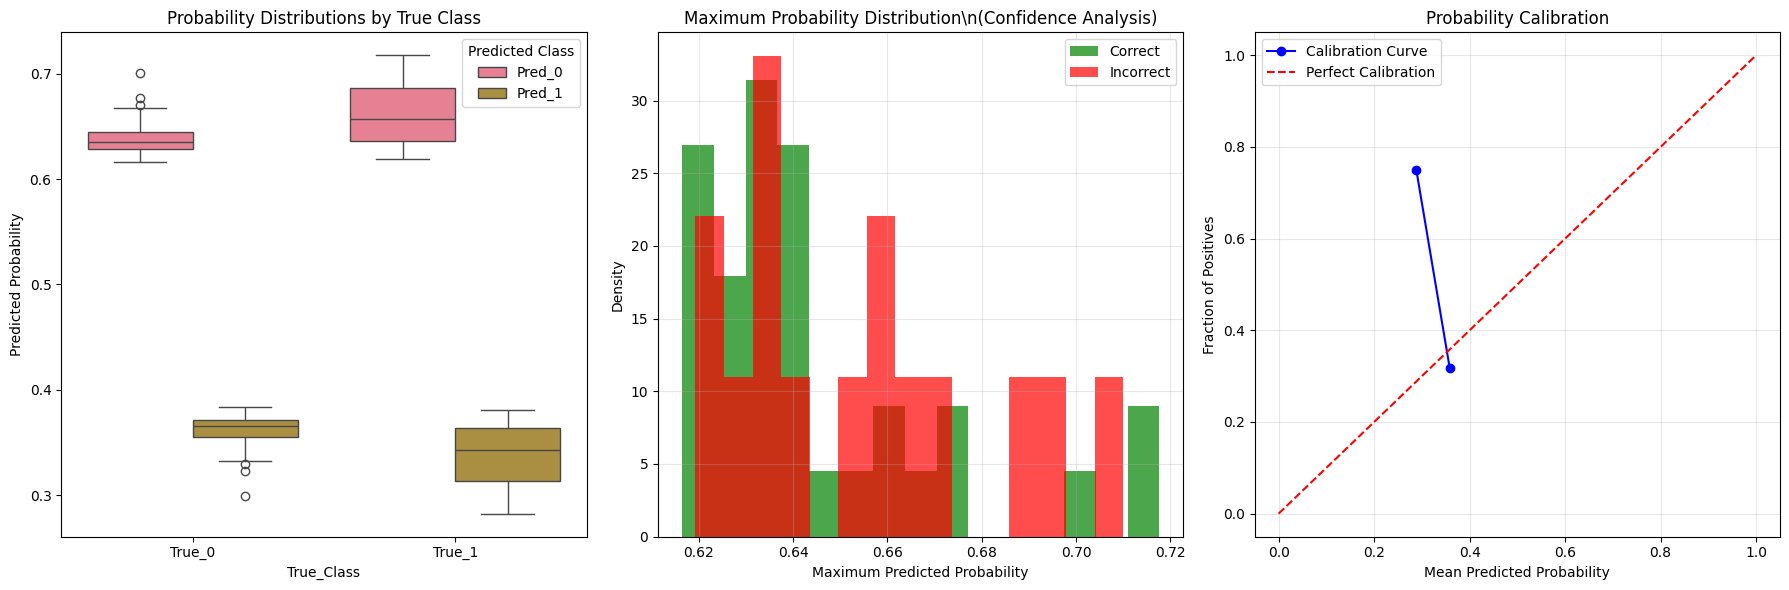


=== Fuzzy SVM Classification Results for Death ===
Test Accuracy: 0.6875
Number of classes: 2
Class distribution in test set:
  Class 0: 31 samples (64.6%)
  Class 1: 17 samples (35.4%)

=== Classification Report ===
              precision    recall  f1-score   support

     Class_0       0.67      1.00      0.81        31
     Class_1       1.00      0.12      0.21        17

    accuracy                           0.69        48
   macro avg       0.84      0.56      0.51        48
weighted avg       0.79      0.69      0.59        48


=== Probability Statistics ===
Class 0 probabilities:
  Mean: 0.6476
  Std:  0.0264
  Min:  0.6164
  Max:  0.7177
Class 1 probabilities:
  Mean: 0.3524
  Std:  0.0264
  Min:  0.2823
  Max:  0.3836
Average maximum probability (confidence): 0.6476
Percentage of predictions with >0.8 confidence: 0.0%

Applying Fuzzy SVM to Relapse
🧠 Implementing Fuzzy SVM Classification for Relapse...
   📊 Training set: 109 samples, Test set: 48 samples
   🎯 Training Fu

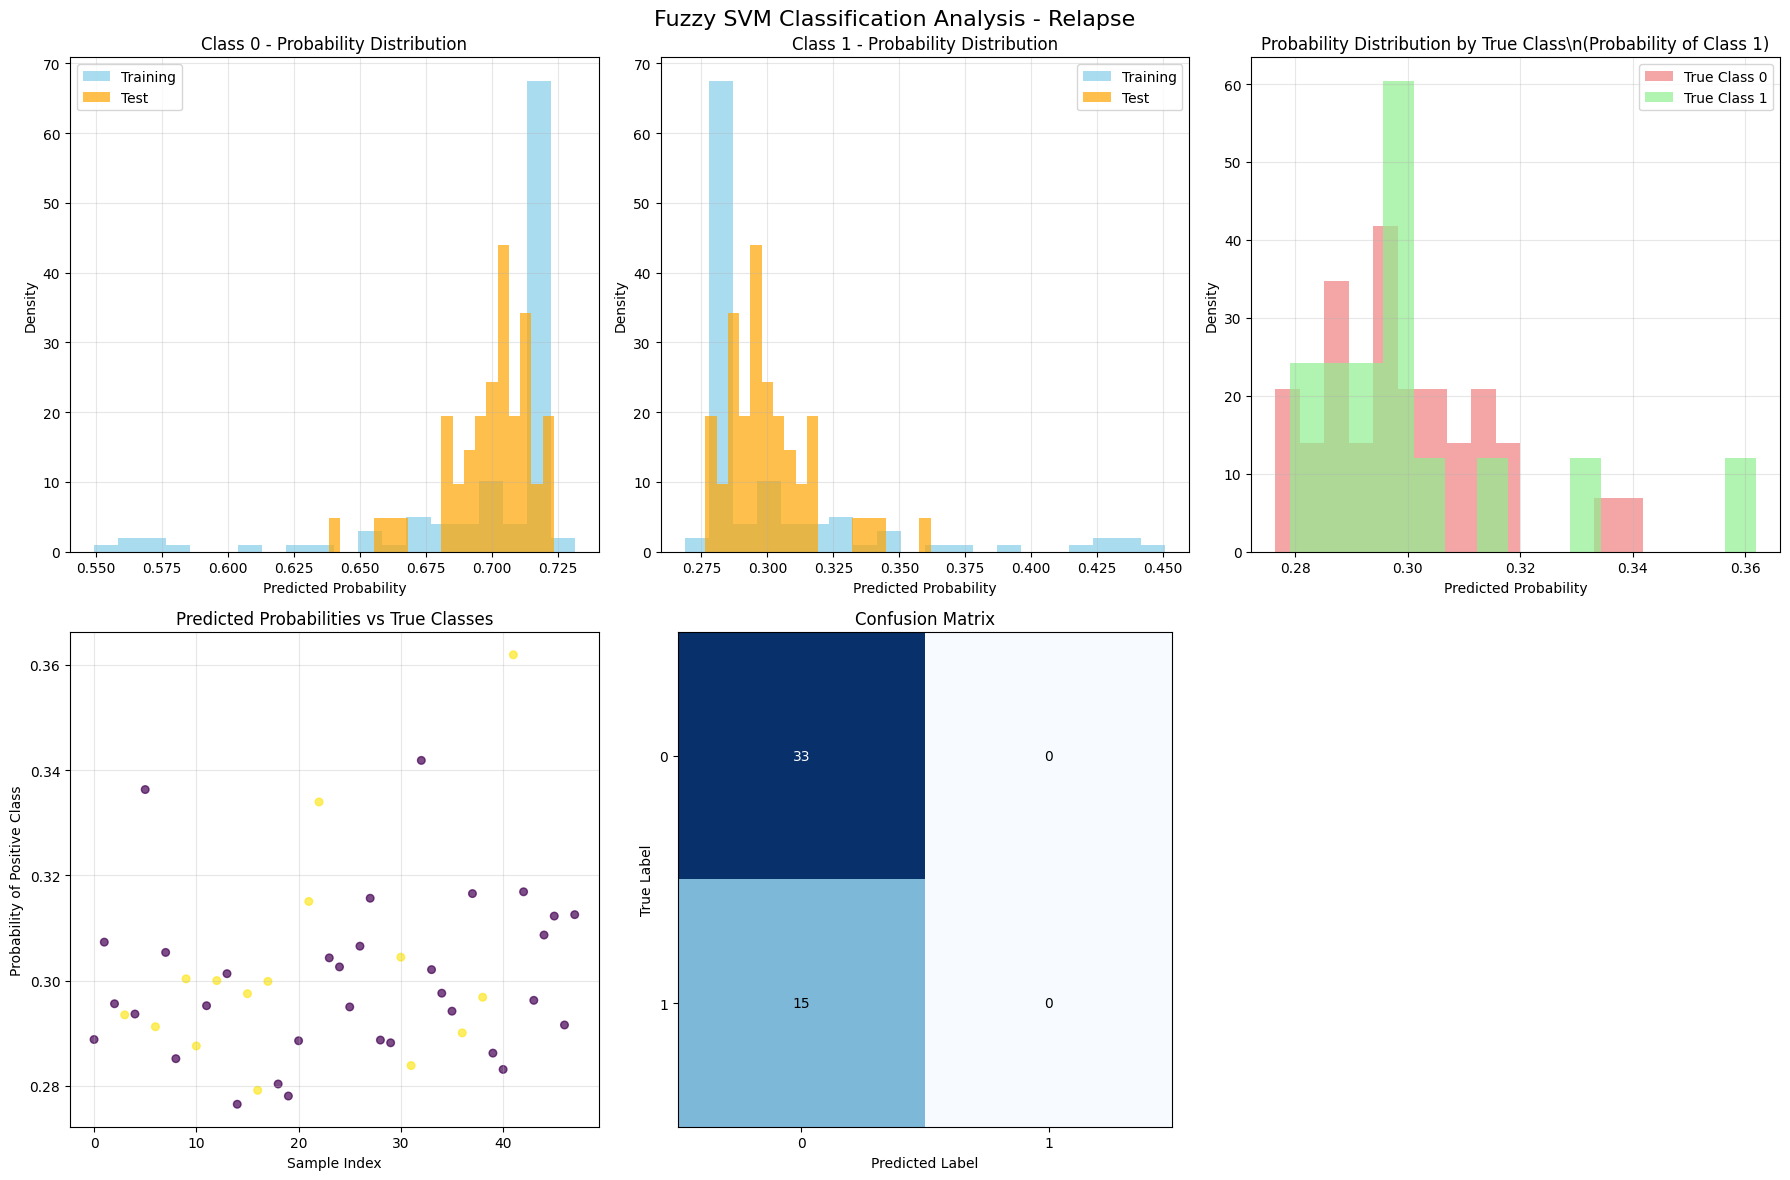

   📈 Creating detailed probability analysis...


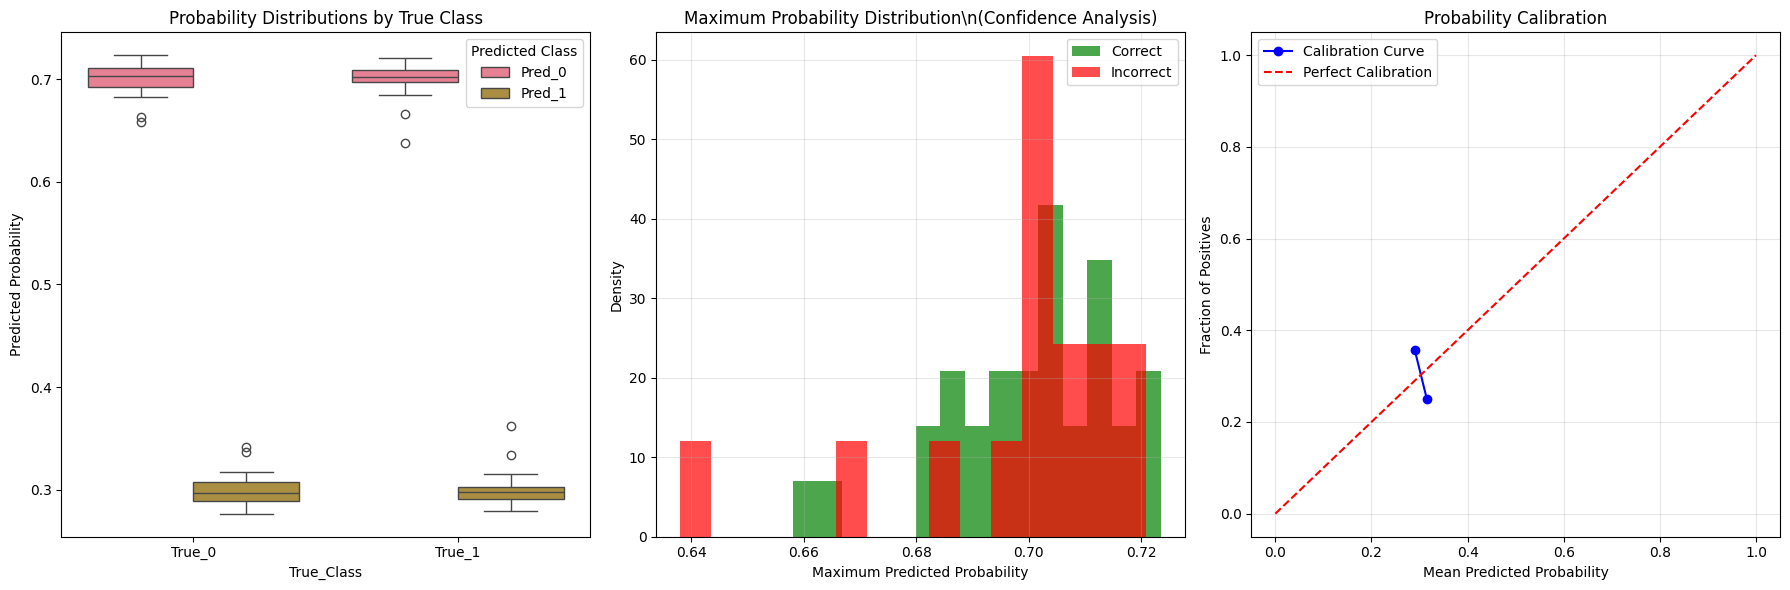


=== Fuzzy SVM Classification Results for Relapse ===
Test Accuracy: 0.6875
Number of classes: 2
Class distribution in test set:
  Class 0: 33 samples (68.8%)
  Class 1: 15 samples (31.2%)

=== Classification Report ===
              precision    recall  f1-score   support

     Class_0       0.69      1.00      0.81        33
     Class_1       0.00      0.00      0.00        15

    accuracy                           0.69        48
   macro avg       0.34      0.50      0.41        48
weighted avg       0.47      0.69      0.56        48


=== Probability Statistics ===
Class 0 probabilities:
  Mean: 0.6994
  Std:  0.0168
  Min:  0.6381
  Max:  0.7235
Class 1 probabilities:
  Mean: 0.3006
  Std:  0.0168
  Min:  0.2765
  Max:  0.3619
Average maximum probability (confidence): 0.6994
Percentage of predictions with >0.8 confidence: 0.0%
✅ Fuzzy SVM classification completed successfully!


In [45]:
def implement_fuzzy_svm_classification(X, y, target_name='Target', test_size=0.3, random_state=42):
    """
    Implement Fuzzy SVM classification with probability distributions.
    
    Parameters:
    -----------
    X : pd.DataFrame or np.array
        Feature matrix
    y : pd.Series or np.array
        Target variable
    target_name : str
        Name of the target variable for plotting
    test_size : float
        Proportion of data for testing
    random_state : int
        Random state for reproducibility
        
    Returns:
    --------
    dict : Dictionary containing classification results and probabilities
    """
    print(f"🧠 Implementing Fuzzy SVM Classification for {target_name}...")
    
    # Prepare data
    X_clean = X.select_dtypes(include=[np.number]).fillna(X.select_dtypes(include=[np.number]).median())
    y_clean = y.dropna()
    
    # Align X and y
    common_indices = X_clean.index.intersection(y_clean.index)
    X_aligned = X_clean.loc[common_indices]
    y_aligned = y_clean.loc[common_indices]
    
    if len(y_aligned.unique()) < 2:
        print(f"⚠️ Insufficient classes for classification ({len(y_aligned.unique())} unique values)")
        return None
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_aligned)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_aligned, test_size=test_size, random_state=random_state, stratify=y_aligned
    )
    
    print(f"   📊 Training set: {len(X_train)} samples, Test set: {len(X_test)} samples")
    
    # Train Fuzzy SVM with probability estimates
    print("   🎯 Training Fuzzy SVM classifier...")
    fuzzy_svm = SVC(
        kernel='rbf',
        probability=True,  # Enable probability estimates
        C=1.0,
        gamma='scale',
        random_state=random_state
    )
    
    fuzzy_svm.fit(X_train, y_train)
    
    # Get predictions and probabilities
    y_pred = fuzzy_svm.predict(X_test)
    y_proba = fuzzy_svm.predict_proba(X_test)
    y_proba_train = fuzzy_svm.predict_proba(X_train)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"   ✅ Test Accuracy: {accuracy:.4f}")
    
    # Get class labels
    classes = fuzzy_svm.classes_
    n_classes = len(classes)
    
    # Create comprehensive probability visualizations
    print("   🎨 Creating probability distribution visualizations...")
    
    # Determine subplot layout
    n_plots = n_classes + 3  # Class distributions + 3 additional plots
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    fig.suptitle(f'Fuzzy SVM Classification Analysis - {target_name}', fontsize=16)
    
    # Flatten axes for easier indexing
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    plot_idx = 0
    
    # Plot: Training probability distributions for each class
    for i, class_label in enumerate(classes):
        if plot_idx < len(axes):
            class_probs_train = y_proba_train[:, i]
            class_probs_test = y_proba[:, i]
            
            axes[plot_idx].hist(class_probs_train, bins=20, alpha=0.7, label='Training', density=True, color='skyblue')
            axes[plot_idx].hist(class_probs_test, bins=20, alpha=0.7, label='Test', density=True, color='orange')
            axes[plot_idx].set_title(f'Class {class_label} - Probability Distribution')
            axes[plot_idx].set_xlabel('Predicted Probability')
            axes[plot_idx].set_ylabel('Density')
            axes[plot_idx].legend()
            axes[plot_idx].grid(True, alpha=0.3)
            plot_idx += 1
    
    # Additional plots for binary classification
    if n_classes == 2 and plot_idx < len(axes):
        # Plot: Probability distributions by true class
        true_class_0_mask = y_test == classes[0]
        true_class_1_mask = y_test == classes[1]
        
        axes[plot_idx].hist(y_proba[true_class_0_mask, 1], bins=15, alpha=0.7, 
                     label=f'True Class {classes[0]}', density=True, color='lightcoral')
        axes[plot_idx].hist(y_proba[true_class_1_mask, 1], bins=15, alpha=0.7, 
                     label=f'True Class {classes[1]}', density=True, color='lightgreen')
        axes[plot_idx].set_title(f'Probability Distribution by True Class\\n(Probability of Class {classes[1]})')
        axes[plot_idx].set_xlabel('Predicted Probability')
        axes[plot_idx].set_ylabel('Density')
        axes[plot_idx].legend()
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
        
        # Plot: Probability vs True Class scatter
        if plot_idx < len(axes):
            axes[plot_idx].scatter(range(len(y_test)), y_proba[:, 1], 
                            c=y_test, cmap='viridis', alpha=0.7, s=30)
            axes[plot_idx].set_title('Predicted Probabilities vs True Classes')
            axes[plot_idx].set_xlabel('Sample Index')
            axes[plot_idx].set_ylabel('Probability of Positive Class')
            axes[plot_idx].grid(True, alpha=0.3)
            plot_idx += 1
    
    # Plot: Confusion matrix
    if plot_idx < len(axes):
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_test, y_pred)
        
        im = axes[plot_idx].imshow(cm, interpolation='nearest', cmap='Blues')
        axes[plot_idx].set_title('Confusion Matrix')
        tick_marks = np.arange(len(classes))
        axes[plot_idx].set_xticks(tick_marks)
        axes[plot_idx].set_xticklabels(classes)
        axes[plot_idx].set_yticks(tick_marks)
        axes[plot_idx].set_yticklabels(classes)
        axes[plot_idx].set_ylabel('True Label')
        axes[plot_idx].set_xlabel('Predicted Label')
        
        # Add text annotations to confusion matrix
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[plot_idx].text(j, i, format(cm[i, j], 'd'),
                            ha="center", va="center",
                            color="white" if cm[i, j] > thresh else "black")
        plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Create detailed probability analysis plots
    print("   📈 Creating detailed probability analysis...")
    
    # Probability distribution comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: Box plot of probabilities by true class
    prob_data = []
    for i, class_label in enumerate(classes):
        for j, true_class in enumerate(classes):
            mask = y_test == true_class
            probs = y_proba[mask, i]
            for prob in probs:
                prob_data.append({
                    'True_Class': f'True_{true_class}',
                    'Predicted_Class': f'Pred_{class_label}',
                    'Probability': prob
                })
    
    prob_df = pd.DataFrame(prob_data)
    
    # Create box plot
    sns.boxplot(data=prob_df, x='True_Class', y='Probability', hue='Predicted_Class', ax=axes[0])
    axes[0].set_title('Probability Distributions by True Class')
    axes[0].set_ylabel('Predicted Probability')
    axes[0].legend(title='Predicted Class')
    
    # Plot 2: Probability confidence (max probability distribution)
    max_probs = np.max(y_proba, axis=1)
    correct_mask = y_pred == y_test
    
    axes[1].hist(max_probs[correct_mask], bins=15, alpha=0.7, label='Correct', density=True, color='green')
    axes[1].hist(max_probs[~correct_mask], bins=15, alpha=0.7, label='Incorrect', density=True, color='red')
    axes[1].set_title('Maximum Probability Distribution\\n(Confidence Analysis)')
    axes[1].set_xlabel('Maximum Predicted Probability')
    axes[1].set_ylabel('Density')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Probability calibration
    if n_classes == 2:
        # Bin probabilities and calculate actual positive rate
        prob_bins = np.linspace(0, 1, 11)
        bin_centers = (prob_bins[:-1] + prob_bins[1:]) / 2
        actual_rates = []
        predicted_rates = []
        
        for i in range(len(prob_bins) - 1):
            mask = (y_proba[:, 1] >= prob_bins[i]) & (y_proba[:, 1] < prob_bins[i+1])
            if mask.sum() > 0:
                actual_rate = (y_test[mask] == classes[1]).mean()
                predicted_rate = y_proba[mask, 1].mean()
                actual_rates.append(actual_rate)
                predicted_rates.append(predicted_rate)
            else:
                actual_rates.append(np.nan)
                predicted_rates.append(np.nan)
        
        axes[2].plot(predicted_rates, actual_rates, 'bo-', label='Calibration Curve')
        axes[2].plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
        axes[2].set_title('Probability Calibration')
        axes[2].set_xlabel('Mean Predicted Probability')
        axes[2].set_ylabel('Fraction of Positives')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    else:
        # For multi-class, show entropy of predictions
        entropy = -np.sum(y_proba * np.log(y_proba + 1e-10), axis=1)
        axes[2].hist(entropy[correct_mask], bins=15, alpha=0.7, label='Correct', density=True, color='green')
        axes[2].hist(entropy[~correct_mask], bins=15, alpha=0.7, label='Incorrect', density=True, color='red')
        axes[2].set_title('Prediction Entropy Distribution')
        axes[2].set_xlabel('Entropy')
        axes[2].set_ylabel('Density')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification results
    print(f"\n=== Fuzzy SVM Classification Results for {target_name} ===")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Number of classes: {n_classes}")
    print(f"Class distribution in test set:")
    for class_label in classes:
        count = np.sum(y_test == class_label)
        percentage = count / len(y_test) * 100
        print(f"  Class {class_label}: {count} samples ({percentage:.1f}%)")
    
    # Print classification report
    print(f"\n=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=[f'Class_{c}' for c in classes]))
    
    # Calculate and print probability statistics
    print(f"\n=== Probability Statistics ===")
    for i, class_label in enumerate(classes):
        class_probs = y_proba[:, i]
        print(f"Class {class_label} probabilities:")
        print(f"  Mean: {np.mean(class_probs):.4f}")
        print(f"  Std:  {np.std(class_probs):.4f}")
        print(f"  Min:  {np.min(class_probs):.4f}")
        print(f"  Max:  {np.max(class_probs):.4f}")
    
    print(f"Average maximum probability (confidence): {np.mean(max_probs):.4f}")
    print(f"Percentage of predictions with >0.8 confidence: {np.mean(max_probs > 0.8)*100:.1f}%")
    
    return {
        'model': fuzzy_svm,
        'scaler': scaler,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'y_proba_train': y_proba_train,
        'classes': classes,
        'accuracy': accuracy,
        'X_test': X_test,
        'X_train': X_train,
        'y_train': y_train,
        'max_probs': max_probs
    }

# Apply Fuzzy SVM classification to different targets
if 'X_ml' in locals() and 'y_ml' in locals():
    fuzzy_svm_results = {}
    target_names = ['RFS', 'Death', 'Relapse']
    
    for i, target_name in enumerate(target_names):
        if i < len(y_ml.columns):
            target_col = y_ml.columns[i]
            print(f"\n{'='*60}")
            print(f"Applying Fuzzy SVM to {target_name}")
            print(f"{'='*60}")
            
            result = implement_fuzzy_svm_classification(X_ml, y_ml[target_col], target_name)
            if result:
                fuzzy_svm_results[target_name] = result
    
    print("✅ Fuzzy SVM classification completed successfully!")

## 11. Fuzzy Classification Analysis

### Fuzzy SVM Classification with Probability Distribution Plots

Implement Fuzzy SVM classification and visualize probability distributions for each class.

In [47]:
def perform_fcm_clustering_with_umap(X, n_clusters=4, random_state=42, m=2.0):
    """
    Perform Fuzzy C-Means clustering and visualize with UMAP 3D reduction.
    
    Parameters:
    -----------
    X : pd.DataFrame or np.array
        Feature matrix
    n_clusters : int
        Number of clusters for FCM
    random_state : int
        Random state for reproducibility
    m : float
        Fuzziness parameter (higher = more fuzzy)
        
    Returns:
    --------
    dict : Dictionary containing FCM results and UMAP coordinates
    """
    print(f"🔮 Performing Fuzzy C-Means clustering (k={n_clusters}) with UMAP 3D visualization...")
    
    # Prepare data - ensure numerical and no missing values
    X_clean = X.select_dtypes(include=[np.number]).fillna(X.select_dtypes(include=[np.number]).median())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    # Perform UMAP dimensionality reduction to 3D (for visualization)
    print("   📊 Applying UMAP dimensionality reduction to 3D...")
    umap_3d = umap.UMAP(n_components=3, random_state=random_state, n_neighbors=15, min_dist=0.1)
    X_umap_3d = umap_3d.fit_transform(X_scaled)
    
    # Perform Fuzzy C-Means clustering on original scaled data
    print("   🎯 Running Fuzzy C-Means clustering...")
    # Note: cmeans expects data in shape (n_features, n_samples)
    X_scaled_T = X_scaled.T
    
    # Run FCM
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_scaled_T, 
        n_clusters, 
        m, 
        error=0.005, 
        maxiter=1000, 
        init=None,
        seed=random_state
    )   
    # Get hard cluster assignments (highest membership)
    cluster_labels = np.argmax(u, axis=0)
    
    # Create 3D visualization with membership probabilities
    print("   🎨 Creating 3D visualization with membership probabilities...")
    
    # Create color palette for clusters
    colors = px.colors.qualitative.Set3[:n_clusters]
    
    # Create multiple visualizations
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}],
               [{"type": "scatter"}, {"type": "scatter"}]],
        subplot_titles=('FCM Clusters (Hard Assignment)', 'FCM Clusters (Membership Strength)',
                       'Membership Probability Distribution', 'Cluster Center Distances'),
        vertical_spacing=0.1
    )
    
    # Plot 1: Hard cluster assignments
    for i in range(n_clusters):
        cluster_mask = cluster_labels == i
        fig.add_trace(
            go.Scatter3d(
                x=X_umap_3d[cluster_mask, 0],
                y=X_umap_3d[cluster_mask, 1],
                z=X_umap_3d[cluster_mask, 2],
                mode='markers',
                marker=dict(
                    size=6,
                    color=colors[i],
                    opacity=0.7
                ),
                name=f'Cluster {i+1}',
                text=[f'Cluster {i+1}<br>Point {j}<br>Max Membership: {u[i,j]:.3f}' 
                      for j in np.where(cluster_mask)[0]],
                hovertemplate='<b>%{text}</b><br>' +
                             'UMAP X: %{x:.2f}<br>' +
                             'UMAP Y: %{y:.2f}<br>' +
                             'UMAP Z: %{z:.2f}<extra></extra>',
                showlegend=True
            ),
            row=1, col=1
        )
    
    # Plot 2: Membership strength visualization (size based on max membership)
    max_memberships = np.max(u, axis=0)
    for i in range(n_clusters):
        cluster_mask = cluster_labels == i
        fig.add_trace(
            go.Scatter3d(
                x=X_umap_3d[cluster_mask, 0],
                y=X_umap_3d[cluster_mask, 1],
                z=X_umap_3d[cluster_mask, 2],
                mode='markers',
                marker=dict(
                    size=max_memberships[cluster_mask] * 15 + 3,  # Scale size by membership
                    color=colors[i],
                    opacity=max_memberships[cluster_mask],  # Transparency by membership
                    line=dict(width=1, color='black')
                ),
                name=f'Cluster {i+1} (Fuzzy)',
                text=[f'Cluster {i+1}<br>Point {j}<br>Membership: {max_memberships[j]:.3f}' 
                      for j in np.where(cluster_mask)[0]],
                hovertemplate='<b>%{text}</b><br>' +
                             'UMAP X: %{x:.2f}<br>' +
                             'UMAP Y: %{y:.2f}<br>' +
                             'UMAP Z: %{z:.2f}<extra></extra>',
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Plot 3: Membership probability distribution
    membership_data = []
    for i in range(n_clusters):
        membership_data.extend([(f'Cluster {i+1}', prob) for prob in u[i, :]])
    
    membership_df = pd.DataFrame(membership_data, columns=['Cluster', 'Membership'])
    
    for i, cluster in enumerate([f'Cluster {j+1}' for j in range(n_clusters)]):
        cluster_memberships = membership_df[membership_df['Cluster'] == cluster]['Membership']
        fig.add_trace(
            go.Histogram(
                x=cluster_memberships,
                name=cluster,
                opacity=0.7,
                nbinsx=20,
                marker_color=colors[i],
                showlegend=False
            ),
            row=2, col=1
        )
    
    # Plot 4: Distance to cluster centers
    sample_indices = np.random.choice(len(cluster_labels), min(100, len(cluster_labels)), replace=False)
    
    for i in range(n_clusters):
        cluster_distances = d[i, sample_indices]
        fig.add_trace(
            go.Scatter(
                x=sample_indices,
                y=cluster_distances,
                mode='markers',
                name=f'Distance to Center {i+1}',
                marker=dict(color=colors[i], size=6),
                showlegend=False
            ),
            row=2, col=2
        )
    
    # Update layout
    fig.update_layout(
        title_text='Fuzzy C-Means Clustering Analysis with UMAP 3D Visualization',
        height=800,
        showlegend=True
    )
    
    # Update 3D subplot layouts
    fig.update_layout(
        scene=dict(
            xaxis_title='UMAP Dim 1',
            yaxis_title='UMAP Dim 2',
            zaxis_title='UMAP Dim 3'
        ),
        scene2=dict(
            xaxis_title='UMAP Dim 1',
            yaxis_title='UMAP Dim 2',
            zaxis_title='UMAP Dim 3'
        )
    )
    
    # Update 2D subplot layouts
    fig.update_xaxes(title_text="Membership Probability", row=2, col=1)
    fig.update_yaxes(title_text="Count", row=2, col=1)
    fig.update_xaxes(title_text="Sample Index", row=2, col=2)
    fig.update_yaxes(title_text="Distance to Center", row=2, col=2)
    
    fig.show()
    
    # Create membership probability heatmap
    print("   🔥 Creating membership probability heatmap...")
    
    # Select a sample of points for visualization
    sample_size = min(50, len(cluster_labels))
    sample_indices = np.random.choice(len(cluster_labels), sample_size, replace=False)
    
    plt.figure(figsize=(12, 8))
    
    # Create heatmap of membership probabilities
    membership_sample = u[:, sample_indices]
    sns.heatmap(
        membership_sample, 
        annot=True, 
        fmt='.2f', 
        cmap='viridis',
        xticklabels=[f'Point {i}' for i in sample_indices],
        yticklabels=[f'Cluster {i+1}' for i in range(n_clusters)],
        cbar_kws={'label': 'Membership Probability'}
    )
    plt.title(f'FCM Membership Probabilities (Sample of {sample_size} points)')
    plt.xlabel('Data Points')
    plt.ylabel('Clusters')
    plt.tight_layout()
    plt.show()
    
    # Calculate FCM statistics
    fcm_stats = {
        'fpc': fpc,  # Fuzzy Partition Coefficient
        'n_clusters': n_clusters,
        'n_points': len(cluster_labels),
        'avg_max_membership': np.mean(np.max(u, axis=0)),
        'cluster_sizes': [np.sum(cluster_labels == i) for i in range(n_clusters)]
    }
    
    # Print FCM summary
    print(f"\n=== Fuzzy C-Means Clustering Results ===")
    print(f"Number of clusters: {n_clusters}")
    print(f"Total data points: {len(cluster_labels)}")
    print(f"Fuzzy Partition Coefficient (FPC): {fpc:.4f}")
    print(f"Average maximum membership: {fcm_stats['avg_max_membership']:.4f}")
    print(f"Objective function value: {jm[-1]:.4f}")
    
    for i, size in enumerate(fcm_stats['cluster_sizes']):
        percentage = size / len(cluster_labels) * 100
        print(f"Cluster {i+1}: {size} points ({percentage:.1f}%)")
    
    return {
        'cluster_labels': cluster_labels,
        'membership_matrix': u,
        'cluster_centers': cntr,
        'umap_coordinates': X_umap_3d,
        'umap_model': umap_3d,
        'scaler': scaler,
        'fcm_stats': fcm_stats,
        'distances': d,
        'X_scaled': X_scaled
    }

# Apply FCM clustering with UMAP
if 'X_ml' in locals():
    fcm_results = perform_fcm_clustering_with_umap(X_ml, n_clusters=4, m=2.0)
    print("✅ Fuzzy C-Means clustering with UMAP completed successfully!")

🔮 Performing Fuzzy C-Means clustering (k=4) with UMAP 3D visualization...
   📊 Applying UMAP dimensionality reduction to 3D...
   🎯 Running Fuzzy C-Means clustering...
   🎨 Creating 3D visualization with membership probabilities...


ValueError: 
    Invalid value of type 'numpy.ndarray' received for the 'opacity' property of scatter3d.marker
        Received value: array([0.25031658, 0.25036026, 0.25011072, 0.25037308, 0.2500266 ,
       0.25012045, 0.25008379, 0.25009296, 0.25037016, 0.25045128,
       0.25050191, 0.25035406, 0.25027628, 0.25034571, 0.25028021,
       0.25012156, 0.25036885, 0.25020329, 0.25019179, 0.25039824,
       0.25011717, 0.25053245, 0.25032223, 0.2502121 , 0.25050185,
       0.25013639, 0.25030733, 0.25045594, 0.25010421, 0.2506111 ,
       0.25012027, 0.25023666, 0.25008901, 0.25024984, 0.2505784 ,
       0.25021995, 0.25046522, 0.25007671, 0.2501861 , 0.25031495,
       0.25056762, 0.25027029, 0.25061671, 0.25039962, 0.25014329,
       0.25003007, 0.25006065, 0.25024458, 0.2500919 , 0.25013695,
       0.25013866, 0.25027898, 0.25026893, 0.25058758, 0.25022709,
       0.25006705, 0.25014947, 0.25027722, 0.25003933, 0.25001612,
       0.25069495, 0.2504581 , 0.25041239, 0.25010099, 0.25022536,
       0.25006657, 0.25022422, 0.25010437, 0.25024789, 0.25023531,
       0.25051831, 0.25022543, 0.2500507 , 0.25041275, 0.25007514,
       0.25008875, 0.250053  , 0.25018038, 0.25053349, 0.25035056,
       0.25033064, 0.2505687 , 0.25055404, 0.25032636, 0.25044747,
       0.25027736, 0.25006395, 0.25006915])

    The 'opacity' property is a number and may be specified as:
      - An int or float in the interval [0, 1]

### Fuzzy C-Means Clustering with UMAP 3D Visualization

Implement Fuzzy C-Means clustering to show soft cluster assignments and membership probabilities.

In [48]:
def perform_kmeans_clustering_with_umap(X, n_clusters=4, random_state=42):
    """
    Perform K-Means clustering and visualize with UMAP 3D reduction.
    
    Parameters:
    -----------
    X : pd.DataFrame or np.array
        Feature matrix
    n_clusters : int
        Number of clusters for K-Means
    random_state : int
        Random state for reproducibility
        
    Returns:
    --------
    dict : Dictionary containing clustering results and UMAP coordinates
    """
    print(f"🔍 Performing K-Means clustering (k={n_clusters}) with UMAP 3D visualization...")
    
    # Prepare data - ensure numerical and no missing values
    X_clean = X.select_dtypes(include=[np.number]).fillna(X.select_dtypes(include=[np.number]).median())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    # Perform K-Means clustering
    print("   🎯 Running K-Means clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Perform UMAP dimensionality reduction to 3D
    print("   📊 Applying UMAP dimensionality reduction to 3D...")
    umap_3d = umap.UMAP(n_components=3, random_state=random_state, n_neighbors=15, min_dist=0.1)
    X_umap_3d = umap_3d.fit_transform(X_scaled)
    
    # Create 3D visualization
    print("   🎨 Creating 3D visualization...")
    
    # Create color palette for clusters
    colors = px.colors.qualitative.Set3[:n_clusters]
    
    # Create 3D scatter plot with Plotly
    fig = go.Figure()
    
    for i in range(n_clusters):
        cluster_mask = cluster_labels == i
        fig.add_trace(go.Scatter3d(
            x=X_umap_3d[cluster_mask, 0],
            y=X_umap_3d[cluster_mask, 1],
            z=X_umap_3d[cluster_mask, 2],
            mode='markers',
            marker=dict(
                size=6,
                color=colors[i],
                opacity=0.7
            ),
            name=f'Cluster {i+1}',
            text=[f'Cluster {i+1}<br>Point {j}' for j in np.where(cluster_mask)[0]],
            hovertemplate='<b>%{text}</b><br>' +
                         'UMAP X: %{x:.2f}<br>' +
                         'UMAP Y: %{y:.2f}<br>' +
                         'UMAP Z: %{z:.2f}<extra></extra>'
        ))
    
    fig.update_layout(
        title='K-Means Clustering with UMAP 3D Visualization',
        scene=dict(
            xaxis_title='UMAP Dimension 1',
            yaxis_title='UMAP Dimension 2',
            zaxis_title='UMAP Dimension 3'
        ),
        width=800,
        height=600
    )
    
    fig.show()
    
    # Calculate cluster statistics
    cluster_stats = {}
    for i in range(n_clusters):
        cluster_mask = cluster_labels == i
        cluster_stats[f'Cluster_{i+1}'] = {
            'size': np.sum(cluster_mask),
            'percentage': np.sum(cluster_mask) / len(cluster_labels) * 100,
            'center_umap': X_umap_3d[cluster_mask].mean(axis=0)
        }
    
    # Print cluster summary
    print(f"\n=== K-Means Clustering Results ===")
    print(f"Number of clusters: {n_clusters}")
    print(f"Total data points: {len(cluster_labels)}")
    print(f"Silhouette score: {kmeans.inertia_:.2f}")
    
    for cluster_name, stats in cluster_stats.items():
        print(f"{cluster_name}: {stats['size']} points ({stats['percentage']:.1f}%)")
    
    return {
        'cluster_labels': cluster_labels,
        'umap_coordinates': X_umap_3d,
        'kmeans_model': kmeans,
        'umap_model': umap_3d,
        'scaler': scaler,
        'cluster_stats': cluster_stats,
        'X_scaled': X_scaled
    }

# Apply K-Means clustering with UMAP
if 'X_ml' in locals():
    kmeans_results = perform_kmeans_clustering_with_umap(X_ml, n_clusters=4)
    print("✅ K-Means clustering with UMAP completed successfully!")

🔍 Performing K-Means clustering (k=4) with UMAP 3D visualization...
   🎯 Running K-Means clustering...
   📊 Applying UMAP dimensionality reduction to 3D...
   🎨 Creating 3D visualization...



=== K-Means Clustering Results ===
Number of clusters: 4
Total data points: 157
Silhouette score: 6875.70
Cluster_1: 22 points (14.0%)
Cluster_2: 118 points (75.2%)
Cluster_3: 14 points (8.9%)
Cluster_4: 3 points (1.9%)
✅ K-Means clustering with UMAP completed successfully!


## 10. Advanced Clustering and Dimensionality Reduction

### K-Means Clustering with UMAP 3D Visualization

Implement K-Means clustering and visualize results using UMAP dimensionality reduction to 3D space.